In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import random, math

In [2]:
timeserise_revenue = pd.read_csv('01_data/time_serise_revenue.zip', compression='zip')
sales_data = pd.read_csv('01_data/time_serise_sale.zip', compression='zip')

In [3]:
def sample_from_table(sample_size: int, dataframe: pd.DataFrame):
    sample_row = dataframe.sample().values[0]
    begin_column = random.randint(0, len(sample_row) - sample_size - 1)
    return sample_row[begin_column: begin_column + sample_size], sample_row[begin_column + 1: begin_column + sample_size + 1]

In [45]:
class FullyConnected(nn.Module):
    def __init__(self, x_size, hidden_size, output_size):
        super(FullyConnected, self).__init__()
        self.hidden_size = hidden_size
        self.linear_with_tanh = nn.Sequential(
            nn.Linear(x_size, self.hidden_size), 
            nn.Tanh(), 
            nn.Linear(self.hidden_size, self.hidden_size), 
            nn.Tanh(), 
            nn.Linear(self.hidden_size, output_size)
        )
    
    def forward(self, x):
        y_hat = self.linear_with_tanh(x)
        return y_hat

### FullyConnected Model

In [85]:
source_data = timeserise_revenue

n_epochs = 100
n_iter = 50
hidden_size = 2
n_layers = 2
batch_size = 5
seq_length = 10
n_sample_size = 50
x_size = 1

d:\zhanghaibin\soft\python\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

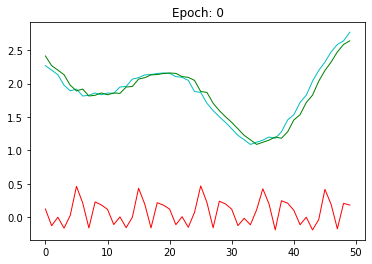

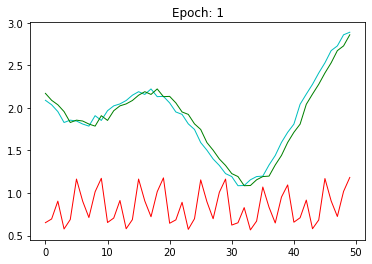

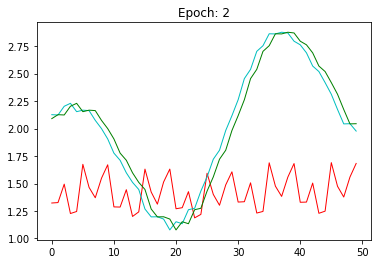

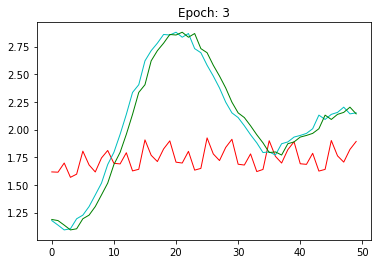

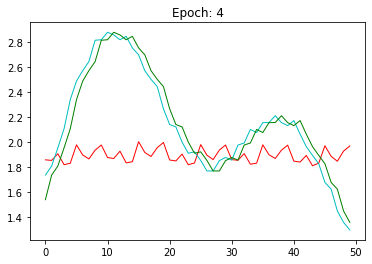

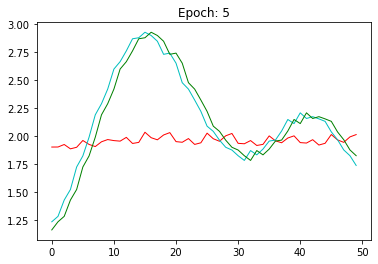

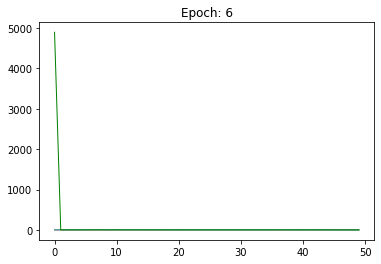

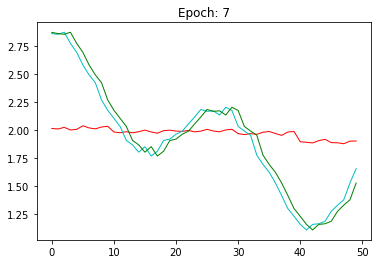

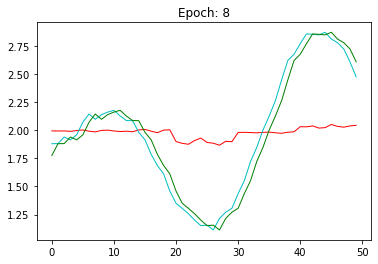

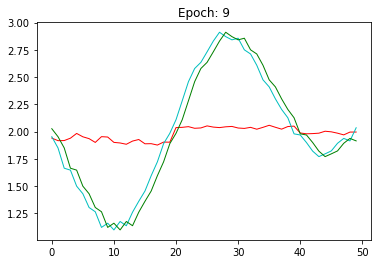

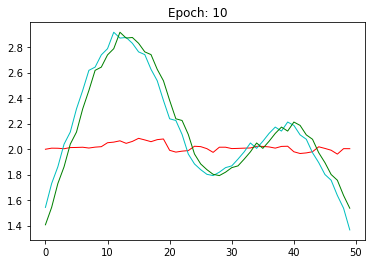

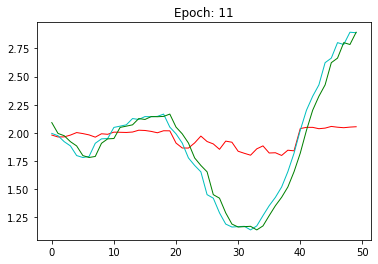

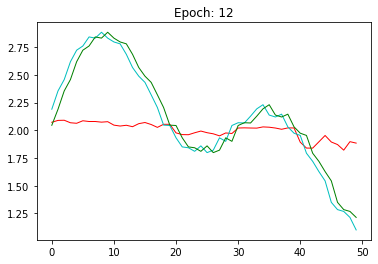

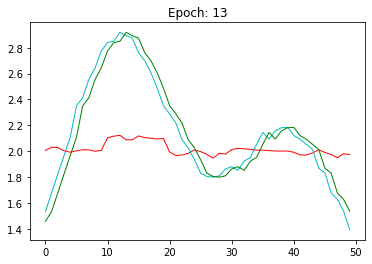

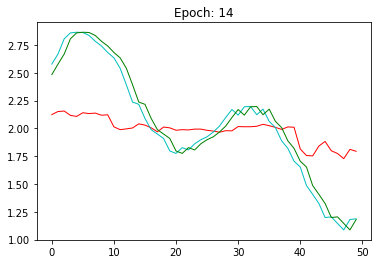

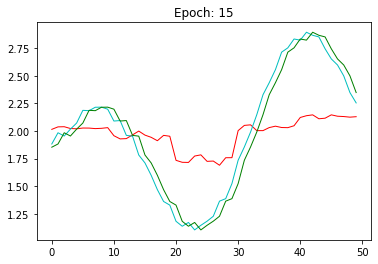

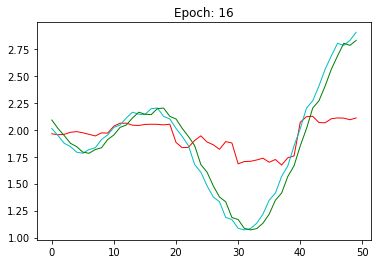

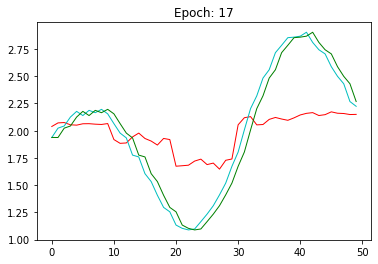

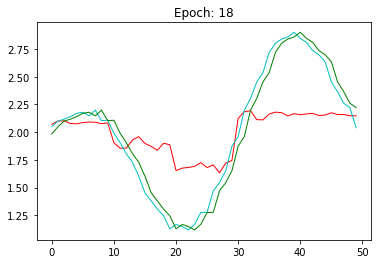

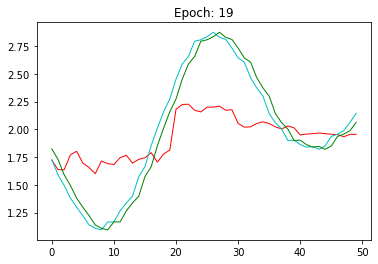

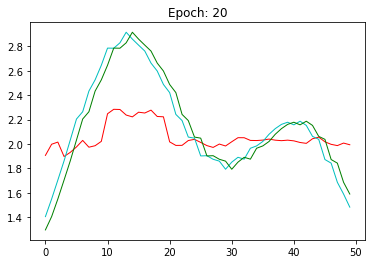

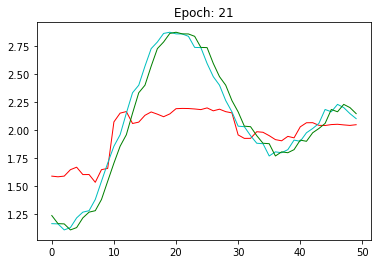

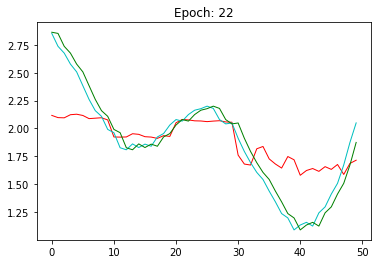

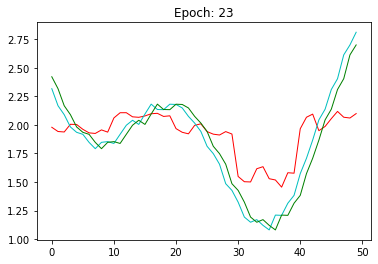

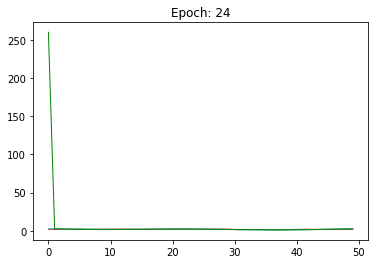

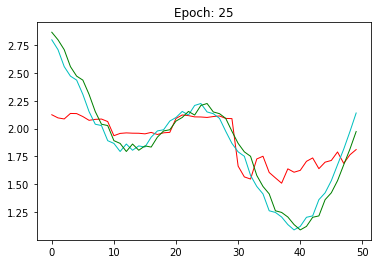

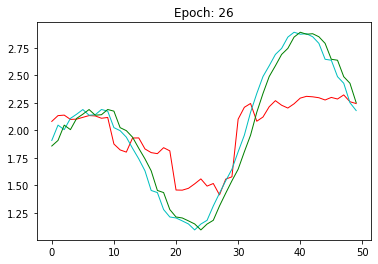

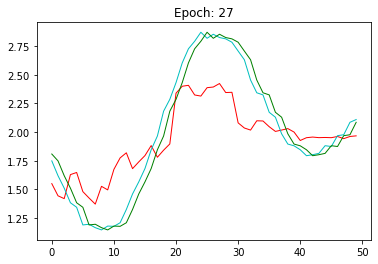

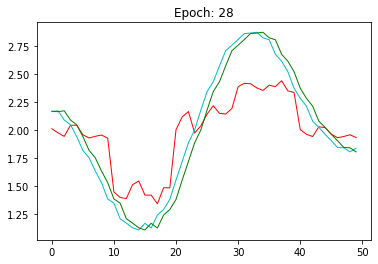

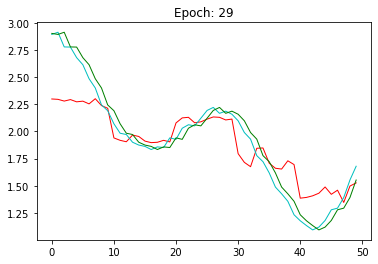

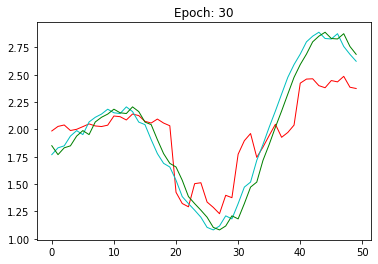

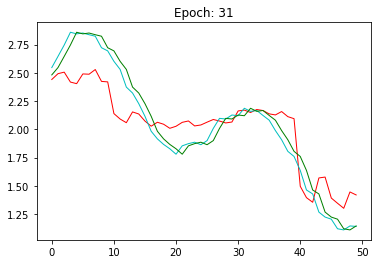

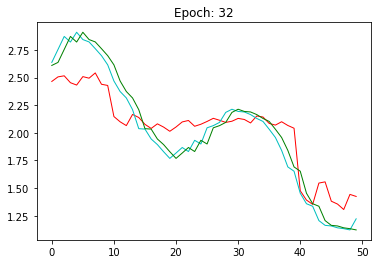

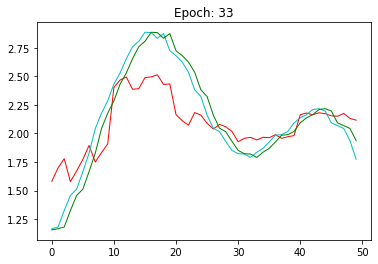

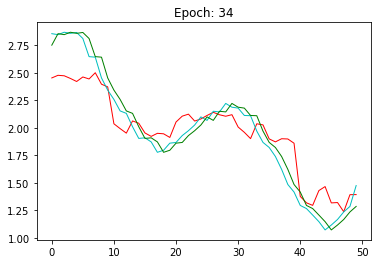

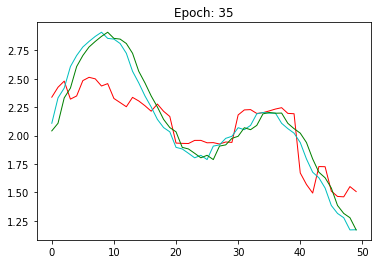

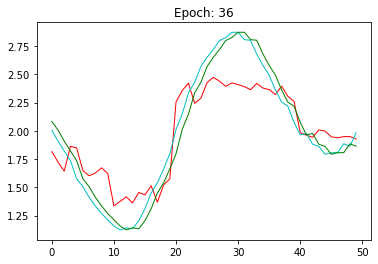

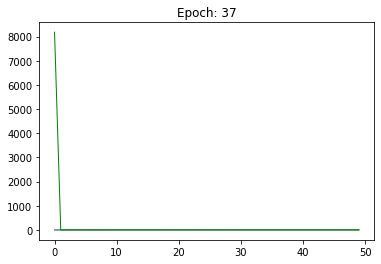

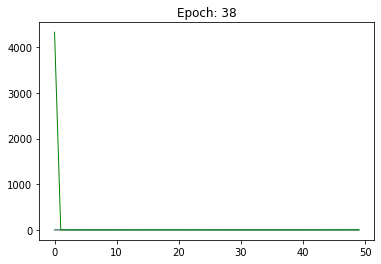

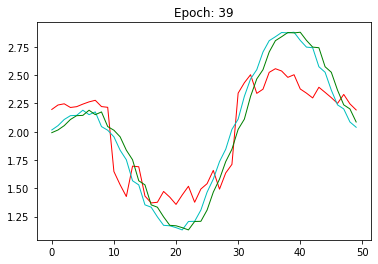

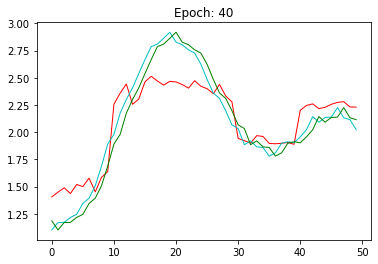

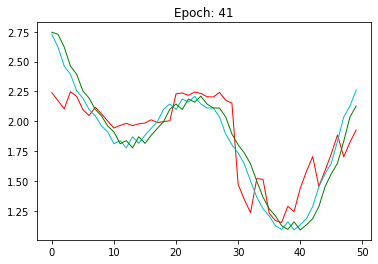

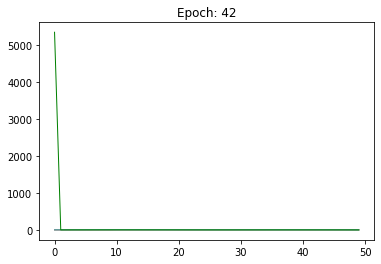

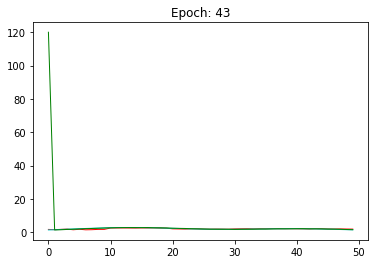

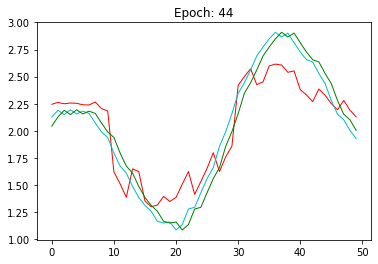

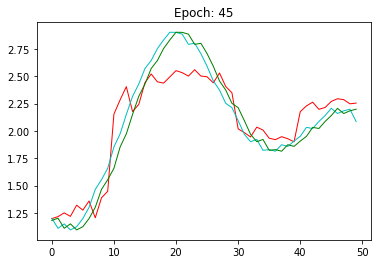

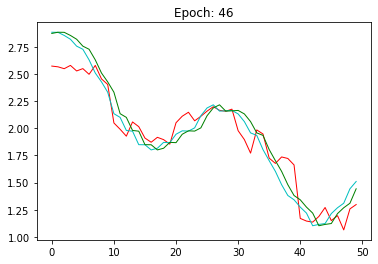

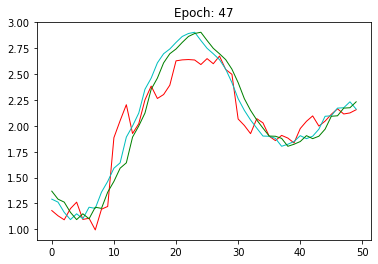

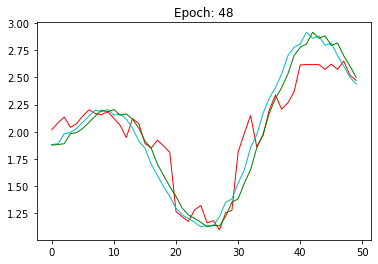

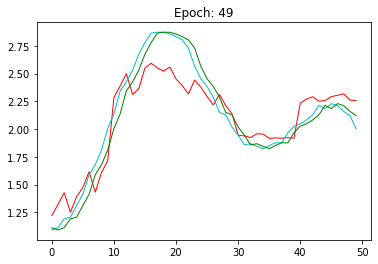

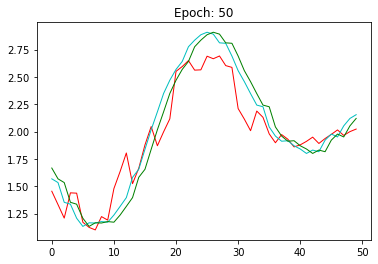

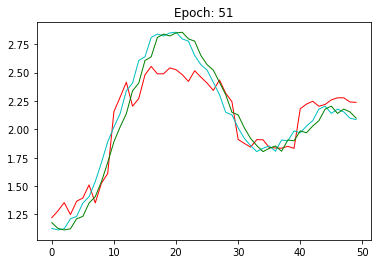

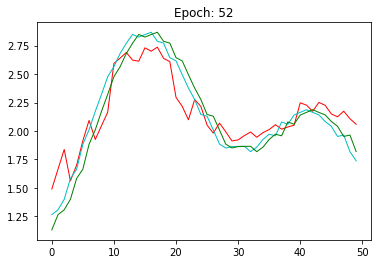

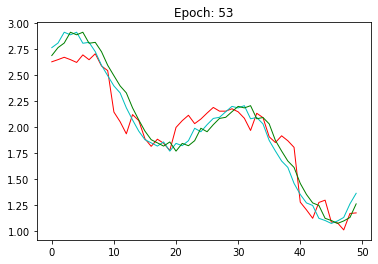

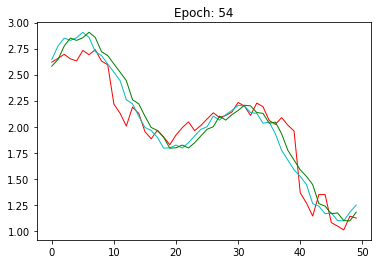

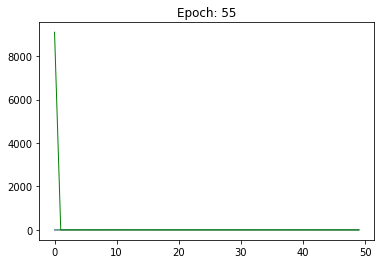

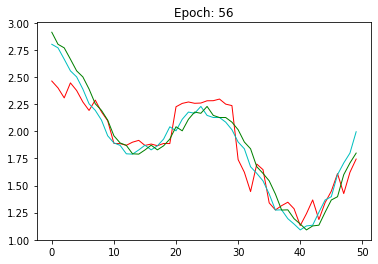

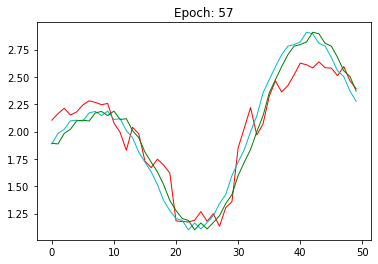

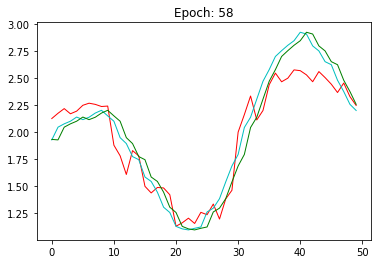

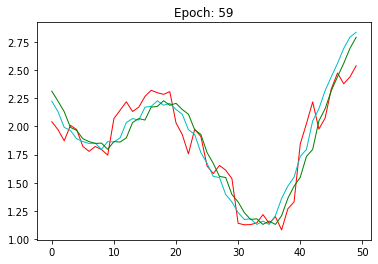

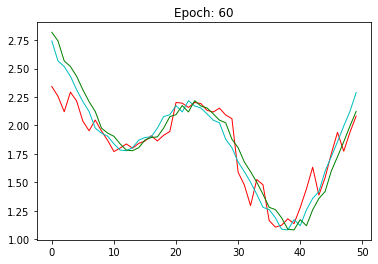

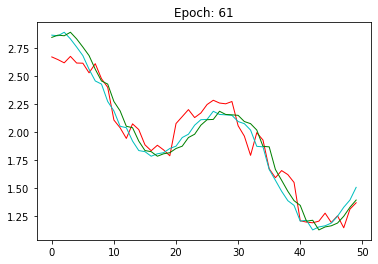

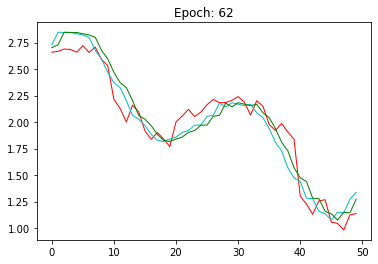

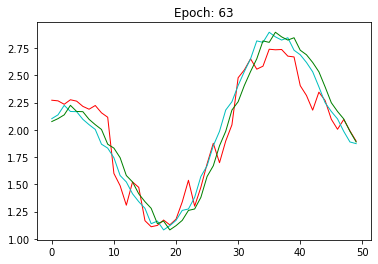

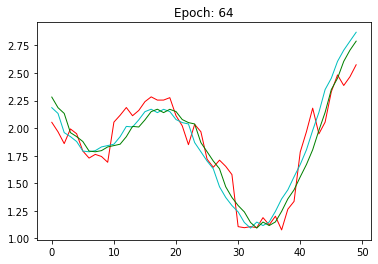

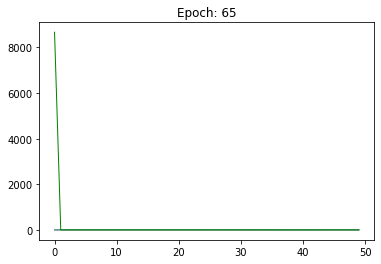

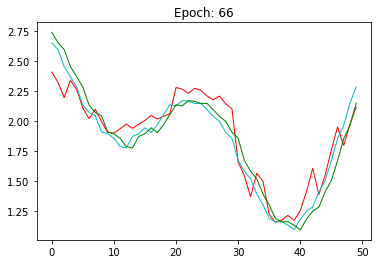

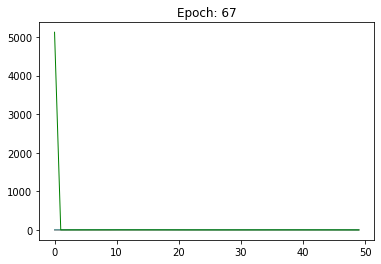

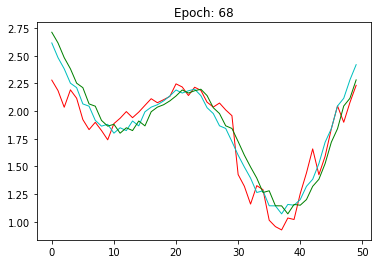

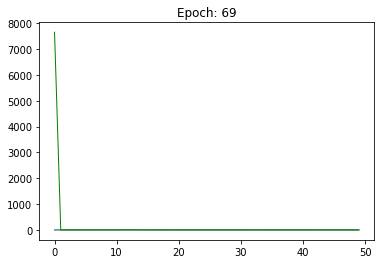

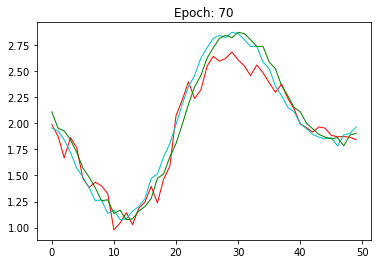

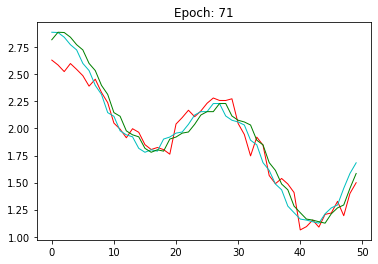

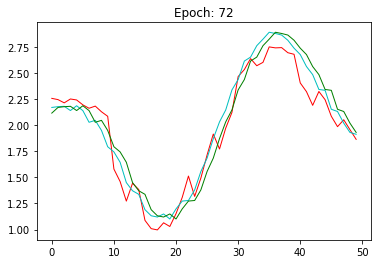

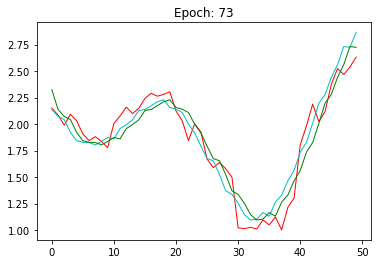

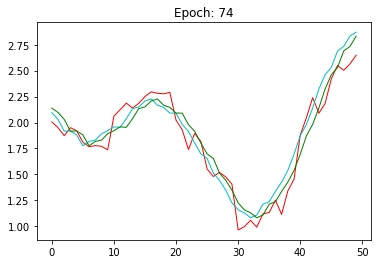

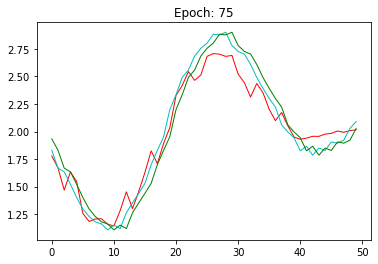

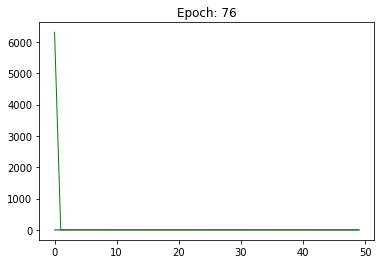

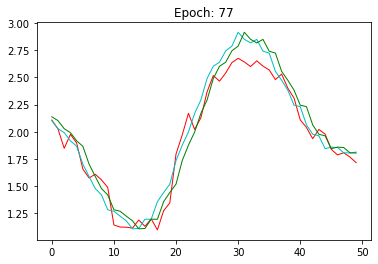

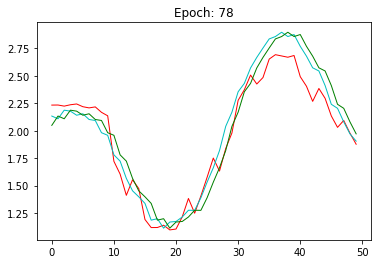

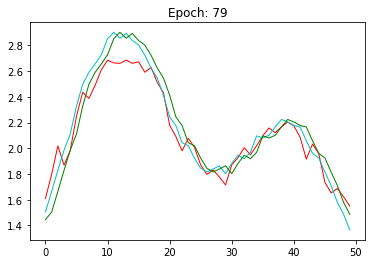

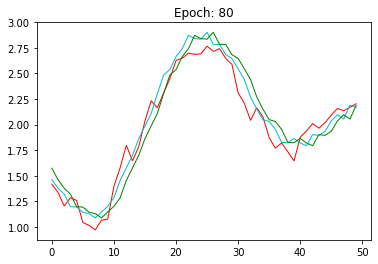

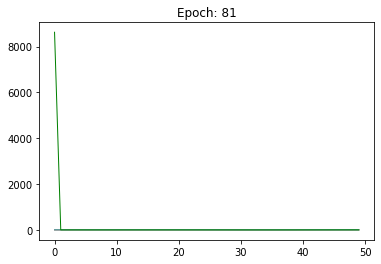

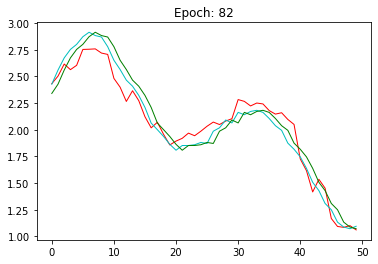

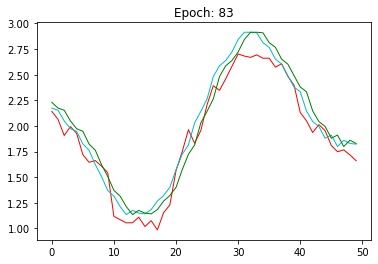

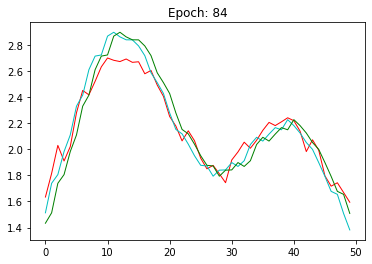

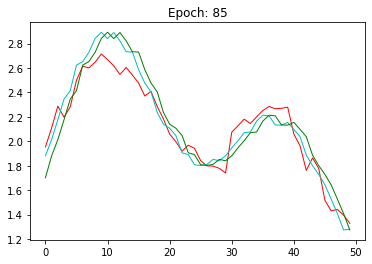

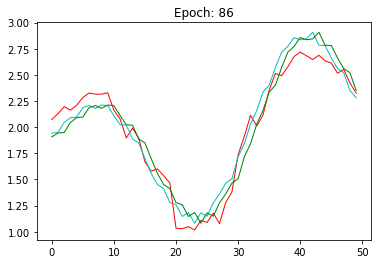

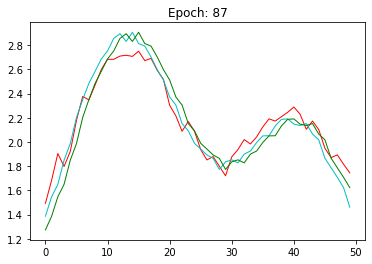

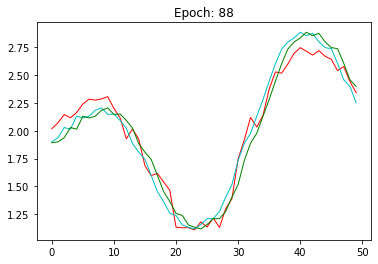

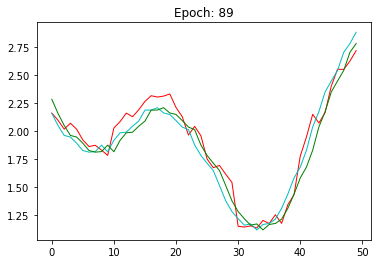

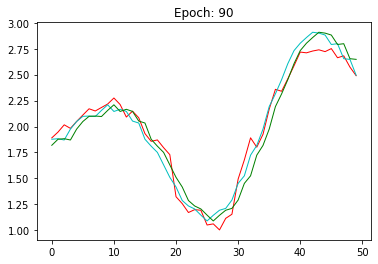

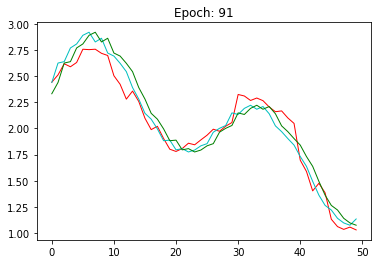

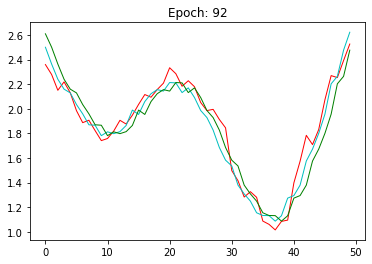

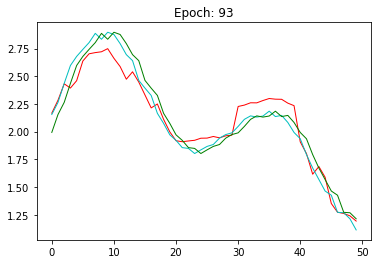

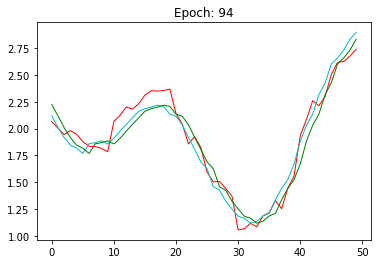

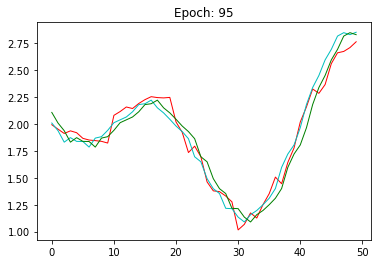

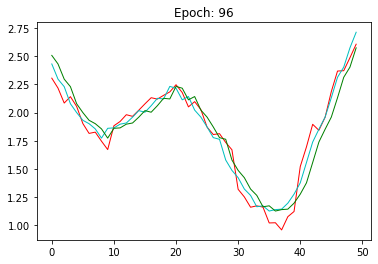

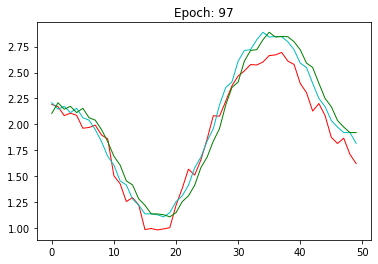

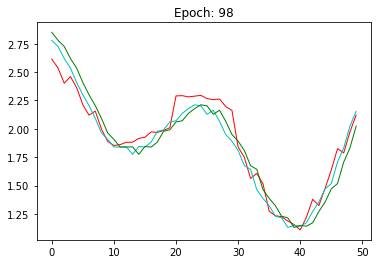

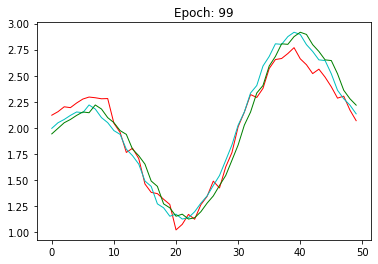

In [86]:
def fit_by_fully_connected_model(source_data, n_sample_size, x_size, hidden_size, output_size, n_epochs=100, n_iter=50, lr=1e-2):
    fc_model = FullyConnected(x_size, hidden_size, output_size=output_size)
    fc_model = fc_model.double()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(fc_model.parameters(), lr=lr)
    losses = np.zeros(n_epochs)
    
    for epoch in tqdm_notebook(range(n_epochs)):
        for n in range(n_iter):
            _inputs, _targets = sample_from_table(n_sample_size, source_data)
            inputs = Variable(
                torch.from_numpy(
                    np.array([
                        _inputs[0:10], 
                        _inputs[10:20], 
                        _inputs[20:30], 
                        _inputs[30:40],
                        _inputs[40:50]], dtype=np.double
                    )
                )
            )
            targets = Variable(
                torch.from_numpy(
                    np.array([
                        _targets[0:10], 
                        _targets[10:20], 
                        _targets[20:30], 
                        _targets[30:40], 
                        _targets[40:50]], dtype=np.double
                    )
                )
            )
            outputs = fc_model(inputs.double())
            # 清空梯度
            optimizer.zero_grad()
            # 计算loss
            loss = criterion(outputs, targets)
            # 反向传播
            loss.backward()
            # 更新参数
            optimizer.step()

            losses[epoch] += loss

            if n % n_iter == 0:
                plt.clf()
                plt.ion()
                plt.title(f'Epoch: {epoch}')
                plt.plot(torch.flatten(outputs.detach()), 'r-', linewidth=1, label='Output')
                plt.plot(torch.flatten(targets), 'c-', linewidth=1, label='Target')
                plt.plot(torch.flatten(inputs), 'g-', linewidth=1, label='Input')
                plt.draw()
                plt.pause(0.05)
    
fit_by_fully_connected_model(source_data, n_sample_size, x_size=10, hidden_size=8, output_size=10)

In [72]:
class SimpleRNN(nn.Module):
    def __init__(self, x_size, hidden_size, n_layers, batch_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        self.rnn = nn.RNN(x_size, hidden_size, n_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, inputs, hidden=None):
        hidden = self.__init__hidden()
        outputs, hidden = self.rnn(inputs.float(), hidden.float())
        outputs = self.output(outputs.float())
        return outputs, hidden
        
        
    def __init__hidden(self):
        hidden = torch.zeros(self.n_layers, self.batch_size, self.hidden_size, dtype=torch.float64)
        return hidden


d:\zhanghaibin\soft\python\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([0.3996, 0.3049, 0.2353, 0.2028, 0.1715, 0.1557, 0.1460, 0.1400, 0.1351,
        0.1338, 0.4069, 0.3019, 0.2270, 0.1910, 0.1641, 0.1507, 0.1454, 0.1437,
        0.1437, 0.1459, 0.3907, 0.2988, 0.2333, 0.2121, 0.1856, 0.1740, 0.1662,
        0.1634, 0.1592, 0.1570, 0.3953, 0.3037, 0.2347, 0.2050, 0.1754, 0.1631,
        0.1562, 0.1496, 0.1481, 0.1476, 0.3894, 0.2986, 0.2303, 0.2097, 0.1803,
        0.1742, 0.1716, 0.1683, 0.1704, 0.1726])
target :  tensor([2.4065, 2.5803, 2.7265, 2.8168, 2.8545, 2.9120, 2.9271, 2.8523, 2.8085,
        2.7882, 2.6928, 2.6294, 2.4927, 2.4427, 2.2834, 2.1943, 2.0947, 2.0062,
        1.9531, 1.8623, 1.8086, 1.7732, 1.7997, 1.8621, 1.8495, 1.9060, 1.9780,
        2.0155, 2.0483, 2.0805, 2.1565, 2.2085, 2.1983, 2.1682, 2.1343, 2.1706,
        2.0455, 1.9679, 1.8662, 1.8037, 1.7606, 1.6088, 1.5272, 1.3549, 1.2651,
        1.2740, 1.1474, 1.1104, 1.0704, 1.1553])
 inputs:  tensor([2.4065, 2.5803, 2.7265, 2.8168, 2.8545, 2.9120, 2.9271, 2.8523, 2.8085,
  

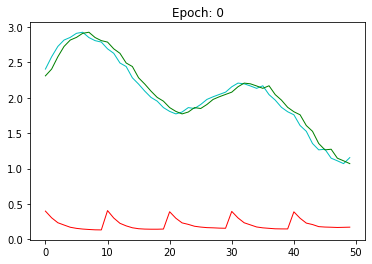

tensor([1.7152, 1.9970, 2.0168, 2.0515, 2.0497, 2.0594, 2.0578, 2.0624, 2.0655,
        2.0727, 1.7324, 2.0310, 2.0509, 2.0916, 2.0912, 2.0968, 2.0986, 2.0940,
        2.0892, 2.0831, 1.7145, 1.9912, 1.9970, 2.0288, 2.0104, 1.9970, 1.9772,
        1.9651, 1.9555, 1.9529, 1.5944, 1.8512, 1.8780, 1.9339, 1.9517, 1.9822,
        2.0046, 2.0308, 2.0549, 2.0707, 1.7393, 2.0493, 2.0794, 2.1263, 2.1357,
        2.1434, 2.1468, 2.1479, 2.1528, 2.1521])
target :  tensor([1.8405, 1.8863, 1.8182, 1.7983, 1.8422, 1.8357, 1.8694, 1.8997, 1.9675,
        2.0675, 2.1290, 2.1257, 2.1969, 2.1498, 2.1773, 2.2075, 2.1309, 2.0904,
        2.0233, 1.9176, 1.7898, 1.7160, 1.6433, 1.4841, 1.3641, 1.2706, 1.2113,
        1.1812, 1.1812, 1.1309, 1.0894, 1.2031, 1.1881, 1.2680, 1.3933, 1.5400,
        1.6948, 1.8769, 1.9731, 2.1283, 2.3140, 2.4082, 2.6185, 2.6975, 2.7589,
        2.8194, 2.8198, 2.9154, 2.8839, 2.8379])
 inputs:  tensor([1.8405, 1.8863, 1.8182, 1.7983, 1.8422, 1.8357, 1.8694, 1.8997, 1.9675,
  

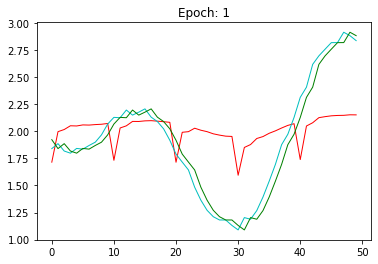

tensor([1.7805, 1.9887, 1.9729, 1.9974, 1.9881, 1.9842, 1.9789, 1.9812, 1.9933,
        1.9974, 1.7549, 1.9819, 1.9814, 2.0220, 2.0329, 2.0510, 2.0474, 2.0451,
        2.0482, 2.0457, 1.7717, 1.9878, 1.9655, 1.9800, 1.9628, 1.9441, 1.9197,
        1.9075, 1.8834, 1.8613, 1.6272, 1.7847, 1.7543, 1.7970, 1.8047, 1.8246,
        1.8405, 1.8812, 1.9091, 1.9404, 1.7477, 1.9850, 1.9996, 2.0552, 2.0778,
        2.1033, 2.1090, 2.1230, 2.1266, 2.1374])
target :  tensor([2.0138, 1.9663, 1.8943, 1.8391, 1.7829, 1.7852, 1.7937, 1.8879, 1.8846,
        1.9158, 2.0131, 2.0420, 2.0752, 2.1258, 2.2136, 2.1667, 2.1423, 2.1771,
        2.1470, 2.0274, 2.0237, 1.9134, 1.7868, 1.6989, 1.5661, 1.4843, 1.4402,
        1.3390, 1.2596, 1.2198, 1.1361, 1.1649, 1.1400, 1.1730, 1.2012, 1.2834,
        1.4531, 1.5478, 1.6797, 1.8698, 2.0488, 2.1718, 2.3227, 2.4479, 2.6184,
        2.6387, 2.7727, 2.7845, 2.9056, 2.8886])
 inputs:  tensor([2.0138, 1.9663, 1.8943, 1.8391, 1.7829, 1.7852, 1.7937, 1.8879, 1.8846,
  

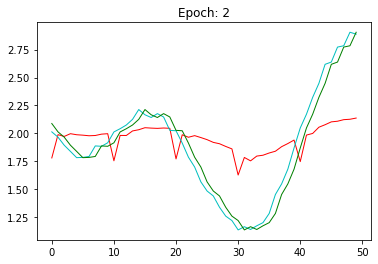

tensor([1.7873, 1.9492, 1.9413, 2.0007, 2.0552, 2.1045, 2.1311, 2.1555, 2.1862,
        2.1994, 2.0186, 2.2081, 2.2070, 2.2147, 2.2190, 2.2134, 2.1958, 2.1902,
        2.1642, 2.1514, 1.9329, 2.0976, 2.0337, 2.0326, 2.0243, 2.0164, 2.0013,
        1.9866, 1.9750, 1.9817, 1.8544, 2.0188, 1.9881, 2.0167, 2.0398, 2.0635,
        2.0729, 2.0768, 2.0908, 2.0931, 1.9194, 2.0768, 2.0244, 2.0410, 2.0199,
        2.0089, 1.9612, 1.9332, 1.8869, 1.8571])
target :  tensor([1.6962, 1.8784, 1.9651, 2.1914, 2.3384, 2.4339, 2.5309, 2.7077, 2.7412,
        2.8740, 2.8270, 2.8870, 2.8162, 2.8447, 2.7735, 2.6603, 2.6447, 2.4755,
        2.4358, 2.2818, 2.2239, 2.0414, 1.9535, 1.9579, 1.8918, 1.8575, 1.7933,
        1.7742, 1.8185, 1.8587, 1.9218, 1.9693, 1.9586, 2.0730, 2.1203, 2.1563,
        2.1453, 2.2279, 2.2096, 2.2028, 2.1274, 2.0374, 2.0150, 1.9225, 1.8621,
        1.6749, 1.6130, 1.4613, 1.4126, 1.2909])
 inputs:  tensor([1.6962, 1.8784, 1.9651, 2.1914, 2.3384, 2.4339, 2.5309, 2.7077, 2.7412,
  

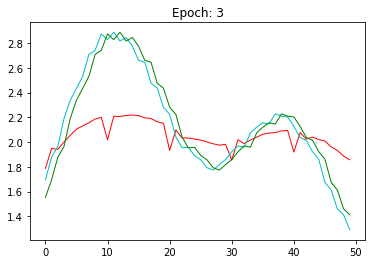

tensor([2.0311, 2.1942, 2.1985, 2.2422, 2.2623, 2.2808, 2.3028, 2.3144, 2.3015,
        2.2984, 2.1150, 2.2713, 2.2251, 2.2154, 2.1803, 2.1571, 2.1199, 2.0882,
        2.0509, 2.0078, 1.9427, 2.0133, 1.9360, 1.9447, 1.9310, 1.9557, 1.9604,
        1.9687, 2.0079, 2.0378, 1.9853, 2.1146, 2.0544, 2.0735, 2.0830, 2.0979,
        2.0713, 2.0580, 2.0225, 1.9983, 1.9260, 1.9860, 1.8460, 1.8185, 1.7498,
        1.7194, 1.6650, 1.6285, 1.5719, 1.5597])
target :  tensor([2.4028, 2.6044, 2.7100, 2.7475, 2.7927, 2.8946, 2.9184, 2.8197, 2.8222,
        2.7266, 2.6731, 2.5745, 2.5138, 2.3798, 2.3061, 2.1972, 2.1159, 2.0210,
        1.9109, 1.9028, 1.7949, 1.8609, 1.8345, 1.8287, 1.8825, 1.8951, 1.9011,
        2.0451, 2.0957, 2.0783, 2.1206, 2.1257, 2.1556, 2.1992, 2.2089, 2.0951,
        2.0715, 1.9584, 1.9201, 1.8381, 1.7206, 1.6033, 1.5297, 1.4138, 1.3536,
        1.2659, 1.2103, 1.1040, 1.1363, 1.1754])
 inputs:  tensor([2.4028, 2.6044, 2.7100, 2.7475, 2.7927, 2.8946, 2.9184, 2.8197, 2.8222,
  

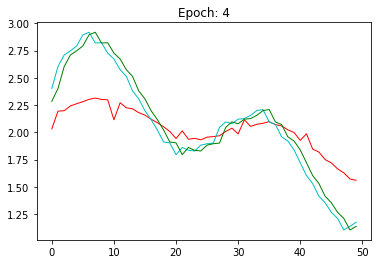

tensor([2.2312, 2.4251, 2.4141, 2.4116, 2.3904, 2.3688, 2.3280, 2.2872, 2.2581,
        2.2179, 2.0751, 2.1667, 2.0666, 2.0282, 1.9573, 1.9207, 1.9124, 1.8971,
        1.8872, 1.8937, 2.0031, 2.0907, 2.0167, 2.0194, 2.0396, 2.0804, 2.1018,
        2.1231, 2.1267, 2.1073, 2.0747, 2.1681, 2.0654, 2.0221, 1.9332, 1.8861,
        1.7913, 1.7184, 1.6647, 1.5805, 1.7535, 1.6927, 1.4661, 1.4185, 1.3799,
        1.4085, 1.4092, 1.4528, 1.5120, 1.5932])
target :  tensor([2.9167, 2.8769, 2.8569, 2.7581, 2.6853, 2.5542, 2.4540, 2.4099, 2.3079,
        2.1719, 2.1019, 2.0427, 1.9589, 1.8470, 1.7904, 1.8446, 1.7965, 1.8009,
        1.8235, 1.9215, 1.9486, 2.0101, 2.0064, 2.1028, 2.1582, 2.1911, 2.2153,
        2.2031, 2.1296, 2.1704, 2.1068, 2.0368, 1.9424, 1.7875, 1.7259, 1.5626,
        1.4793, 1.4400, 1.2948, 1.2201, 1.1967, 1.1338, 1.1145, 1.1365, 1.1899,
        1.1919, 1.2800, 1.3820, 1.5124, 1.6887])
 inputs:  tensor([2.9167, 2.8769, 2.8569, 2.7581, 2.6853, 2.5542, 2.4540, 2.4099, 2.3079,
  

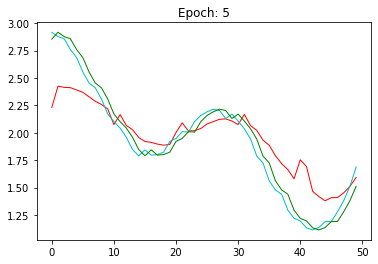

tensor([2.2743, 2.4362, 2.3974, 2.3597, 2.2780, 2.2134, 2.1499, 2.0848, 2.0276,
        1.9982, 1.9968, 2.0342, 1.9353, 1.9303, 1.8938, 1.9389, 1.9526, 1.9965,
        2.0431, 2.0693, 2.1275, 2.2435, 2.1944, 2.1944, 2.1691, 2.1432, 2.1044,
        2.0598, 2.0116, 1.9556, 1.9778, 1.9412, 1.7462, 1.6404, 1.5127, 1.4315,
        1.3394, 1.3039, 1.2633, 1.2712, 1.7500, 1.6820, 1.4831, 1.4848, 1.5216,
        1.6518, 1.7641, 1.9146, 2.0527, 2.1690])
target :  tensor([2.6331, 2.5410, 2.4347, 2.2462, 2.1432, 2.0716, 1.9746, 1.9182, 1.9143,
        1.7980, 1.7800, 1.8527, 1.8563, 1.8190, 1.9222, 1.9246, 2.0030, 2.0706,
        2.0768, 2.1812, 2.1818, 2.2208, 2.2139, 2.1689, 2.0954, 2.0444, 1.9681,
        1.9106, 1.8295, 1.7476, 1.5868, 1.5473, 1.4125, 1.3246, 1.2199, 1.1573,
        1.1483, 1.1171, 1.1664, 1.2136, 1.2676, 1.2960, 1.3782, 1.5066, 1.7013,
        1.8280, 2.0386, 2.2039, 2.3378, 2.4055])
 inputs:  tensor([2.6331, 2.5410, 2.4347, 2.2462, 2.1432, 2.0716, 1.9746, 1.9182, 1.9143,
  

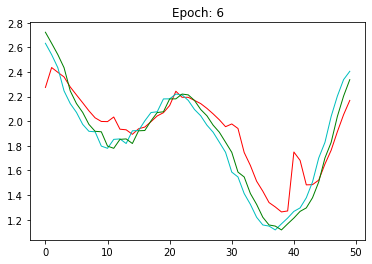

tensor([2.0140, 1.9653, 1.7632, 1.6678, 1.5278, 1.4510, 1.3316, 1.2367, 1.1792,
        1.1716, 1.6493, 1.5086, 1.3214, 1.3226, 1.3355, 1.4412, 1.5765, 1.6965,
        1.8540, 2.0044, 2.1677, 2.3460, 2.3716, 2.4390, 2.4961, 2.5330, 2.5517,
        2.5656, 2.5682, 2.5676, 2.2944, 2.4806, 2.4492, 2.4118, 2.3620, 2.2964,
        2.2210, 2.1469, 2.0732, 2.0169, 2.0198, 2.0689, 1.9112, 1.9019, 1.8794,
        1.8817, 1.8942, 1.9438, 1.9996, 2.0133])
target :  tensor([1.6702, 1.6123, 1.5260, 1.4117, 1.3388, 1.2233, 1.1317, 1.1236, 1.1552,
        1.0816, 1.1408, 1.2562, 1.3048, 1.3810, 1.5247, 1.7146, 1.7977, 2.0115,
        2.1607, 2.2839, 2.4316, 2.5531, 2.6898, 2.7907, 2.8225, 2.8385, 2.8630,
        2.8516, 2.8442, 2.7216, 2.7154, 2.5809, 2.4838, 2.3952, 2.2546, 2.1515,
        2.0545, 1.9753, 1.9307, 1.8721, 1.8866, 1.7902, 1.8587, 1.8597, 1.8453,
        1.8906, 1.9740, 2.0482, 2.0080, 2.1084])
 inputs:  tensor([1.6702, 1.6123, 1.5260, 1.4117, 1.3388, 1.2233, 1.1317, 1.1236, 1.1552,
  

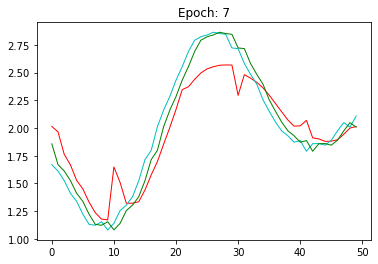

tensor([2.0266, 2.1027, 2.0369, 2.0733, 2.0996, 2.1338, 2.1456, 2.1726, 2.1892,
        2.1871, 2.1240, 2.1945, 2.0920, 2.0184, 1.9046, 1.8138, 1.6924, 1.5958,
        1.4873, 1.3971, 1.7066, 1.4905, 1.2297, 1.1575, 1.0806, 1.1041, 1.1463,
        1.2450, 1.3269, 1.4409, 1.9586, 2.0227, 2.0036, 2.0837, 2.1928, 2.3157,
        2.4114, 2.4737, 2.5288, 2.5656, 2.3723, 2.5826, 2.6147, 2.5930, 2.5929,
        2.5650, 2.5165, 2.4640, 2.4182, 2.3424])
target :  tensor([1.9667, 2.0227, 2.0964, 2.1381, 2.1483, 2.1522, 2.1926, 2.2046, 2.1779,
        2.1065, 2.0762, 2.0286, 1.9125, 1.7925, 1.6868, 1.5751, 1.4973, 1.4008,
        1.3320, 1.2137, 1.1219, 1.1575, 1.1082, 1.0916, 1.1376, 1.2329, 1.3586,
        1.4323, 1.5647, 1.7113, 1.8637, 2.0485, 2.1591, 2.3417, 2.4878, 2.6098,
        2.6648, 2.7589, 2.8067, 2.9031, 2.9110, 2.9156, 2.7954, 2.8147, 2.7129,
        2.5933, 2.4964, 2.4355, 2.2872, 2.2026])
 inputs:  tensor([1.9667, 2.0227, 2.0964, 2.1381, 2.1483, 2.1522, 2.1926, 2.2046, 2.1779,
  

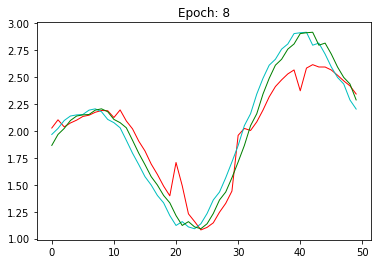

tensor([2.2003, 2.3873, 2.4237, 2.4883, 2.5504, 2.6203, 2.6520, 2.6508, 2.6533,
        2.6470, 2.3607, 2.5445, 2.5264, 2.4766, 2.4325, 2.3493, 2.2722, 2.2020,
        2.1326, 2.0349, 2.0242, 2.0366, 1.8880, 1.8664, 1.8459, 1.8618, 1.9212,
        1.9682, 2.0307, 2.0525, 2.1514, 2.2582, 2.2076, 2.2012, 2.1794, 2.1902,
        2.1719, 2.1329, 2.0718, 2.0037, 2.0213, 1.9770, 1.7704, 1.6424, 1.4706,
        1.3947, 1.2744, 1.2076, 1.1593, 1.1153])
target :  tensor([2.4427, 2.5434, 2.6421, 2.7470, 2.8810, 2.9013, 2.8518, 2.8619, 2.8383,
        2.7698, 2.7276, 2.6139, 2.4787, 2.4240, 2.2447, 2.1670, 2.0866, 2.0186,
        1.8851, 1.8456, 1.8308, 1.7876, 1.7993, 1.8163, 1.8194, 1.9427, 1.9593,
        2.0472, 2.0204, 2.1460, 2.1780, 2.1809, 2.1594, 2.1381, 2.1516, 2.1165,
        2.0430, 1.9619, 1.8853, 1.8391, 1.7207, 1.6363, 1.4957, 1.3604, 1.3175,
        1.2072, 1.1720, 1.1514, 1.1086, 1.1757])
 inputs:  tensor([2.4427, 2.5434, 2.6421, 2.7470, 2.8810, 2.9013, 2.8518, 2.8619, 2.8383,
  

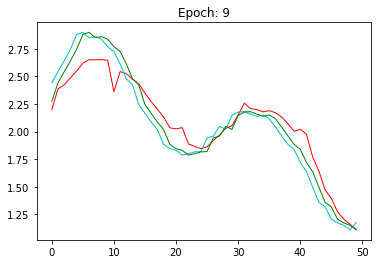

tensor([1.6157, 1.3808, 1.1387, 1.1221, 1.0818, 1.1594, 1.2402, 1.3241, 1.4370,
        1.5717, 1.9753, 2.0606, 2.0663, 2.2062, 2.3073, 2.4158, 2.4915, 2.5419,
        2.6091, 2.6353, 2.3801, 2.5641, 2.5840, 2.5747, 2.5641, 2.5111, 2.4602,
        2.3973, 2.3256, 2.2514, 2.0905, 2.1256, 1.9827, 1.9434, 1.8620, 1.8408,
        1.8233, 1.8236, 1.8369, 1.8940, 2.0374, 2.0773, 2.0166, 2.0618, 2.1198,
        2.1740, 2.1678, 2.1724, 2.1699, 2.1548])
target :  tensor([1.1083, 1.1482, 1.1520, 1.1449, 1.2580, 1.3625, 1.4273, 1.5630, 1.6974,
        1.7970, 1.9744, 2.1407, 2.3509, 2.4463, 2.5816, 2.6741, 2.7286, 2.8789,
        2.8835, 2.8749, 2.8168, 2.7913, 2.7336, 2.7056, 2.5522, 2.4798, 2.3734,
        2.2715, 2.1762, 2.0493, 2.0057, 1.9082, 1.8873, 1.8023, 1.7947, 1.8042,
        1.8072, 1.8379, 1.9283, 1.9294, 1.9550, 2.0250, 2.0889, 2.1857, 2.2043,
        2.1536, 2.1616, 2.1573, 2.1252, 2.0909])
 inputs:  tensor([1.1083, 1.1482, 1.1520, 1.1449, 1.2580, 1.3625, 1.4273, 1.5630, 1.6974,
  

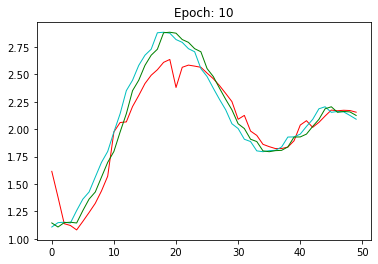

tensor([2.2962, 2.4340, 2.3815, 2.3255, 2.2334, 2.1766, 2.1037, 2.0597, 1.9591,
        1.9354, 2.0096, 1.9782, 1.8720, 1.8695, 1.8845, 1.9562, 1.9930, 2.0674,
        2.1068, 2.1480, 2.1438, 2.2601, 2.1999, 2.2012, 2.1837, 2.1375, 2.1086,
        2.0259, 1.9072, 1.8053, 1.8691, 1.7113, 1.4529, 1.3478, 1.2279, 1.1618,
        1.1423, 1.1394, 1.1125, 1.1446, 1.6307, 1.5453, 1.3707, 1.4941, 1.5905,
        1.7593, 1.8949, 2.0418, 2.2123, 2.3320])
target :  tensor([2.5012, 2.3828, 2.2706, 2.1386, 2.0801, 2.0045, 1.9766, 1.8326, 1.8777,
        1.8643, 1.7934, 1.8460, 1.8295, 1.8905, 1.9597, 1.9895, 2.0853, 2.1015,
        2.1453, 2.1586, 2.2296, 2.1793, 2.1774, 2.1540, 2.0460, 2.0488, 1.9064,
        1.7717, 1.6886, 1.5932, 1.4532, 1.3887, 1.2797, 1.2126, 1.1269, 1.1835,
        1.1625, 1.1398, 1.2019, 1.1905, 1.3659, 1.3849, 1.5980, 1.6787, 1.8615,
        1.9696, 2.1255, 2.3377, 2.4388, 2.5264])
 inputs:  tensor([2.5012, 2.3828, 2.2706, 2.1386, 2.0801, 2.0045, 1.9766, 1.8326, 1.8777,
  

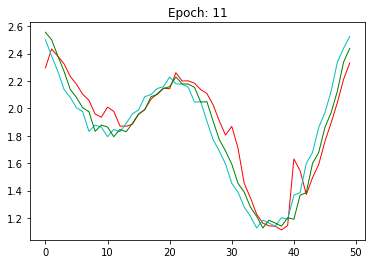

tensor([2.1171, 2.1247, 2.0107, 1.9833, 1.9330, 1.9132, 1.8759, 1.8468, 1.8519,
        1.9298, 2.0725, 2.1245, 2.0820, 2.1350, 2.1226, 2.1855, 2.1908, 2.2043,
        2.1865, 2.1715, 2.1286, 2.1279, 1.9628, 1.8978, 1.7924, 1.6799, 1.5963,
        1.4790, 1.3510, 1.2461, 1.5714, 1.3306, 1.0984, 1.1199, 1.0798, 1.1461,
        1.2065, 1.3202, 1.4371, 1.5630, 2.0062, 2.0889, 2.1224, 2.2232, 2.3368,
        2.4432, 2.5201, 2.5828, 2.6421, 2.6582])
target :  tensor([1.9909, 1.9618, 1.9214, 1.8800, 1.8417, 1.8178, 1.7823, 1.8235, 1.9486,
        1.9964, 2.0236, 2.0913, 2.1466, 2.0909, 2.1930, 2.1624, 2.1791, 2.1341,
        2.1217, 2.1174, 1.9883, 1.8744, 1.8094, 1.7111, 1.5588, 1.5390, 1.3888,
        1.2877, 1.1979, 1.1258, 1.1084, 1.1338, 1.1643, 1.1221, 1.2134, 1.2843,
        1.4165, 1.5258, 1.6457, 1.8617, 2.0073, 2.2017, 2.2889, 2.4477, 2.5617,
        2.6618, 2.7506, 2.8600, 2.8449, 2.8471])
 inputs:  tensor([1.9909, 1.9618, 1.9214, 1.8800, 1.8417, 1.8178, 1.7823, 1.8235, 1.9486,
  

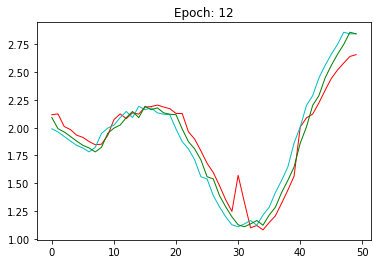

tensor([1.5542, 1.3397, 1.1989, 1.2421, 1.3586, 1.4675, 1.5964, 1.7674, 1.9455,
        2.0768, 2.2258, 2.4146, 2.4668, 2.5224, 2.5937, 2.6432, 2.6829, 2.6907,
        2.6798, 2.6697, 2.3714, 2.5571, 2.5180, 2.4758, 2.4043, 2.3316, 2.2593,
        2.2088, 2.0977, 2.0104, 2.0366, 2.0333, 1.8859, 1.8462, 1.8370, 1.8970,
        1.9571, 2.0161, 2.0249, 2.0754, 2.1158, 2.1866, 2.1352, 2.2071, 2.2287,
        2.2259, 2.2137, 2.1672, 2.0958, 2.0085])
target :  tensor([1.1441, 1.2798, 1.2753, 1.4697, 1.5049, 1.6694, 1.8326, 2.0211, 2.1081,
        2.3309, 2.4910, 2.5876, 2.6350, 2.7606, 2.8155, 2.8860, 2.8696, 2.8284,
        2.8105, 2.7198, 2.7266, 2.5568, 2.4725, 2.3489, 2.2360, 2.1628, 2.1178,
        1.9548, 1.8879, 1.9210, 1.8853, 1.8225, 1.7715, 1.8102, 1.8704, 1.9504,
        1.9935, 1.9715, 2.0543, 2.0826, 2.1037, 2.1214, 2.2260, 2.2161, 2.1641,
        2.1590, 2.0729, 1.9843, 1.8832, 1.8503])
 inputs:  tensor([1.1441, 1.2798, 1.2753, 1.4697, 1.5049, 1.6694, 1.8326, 2.0211, 2.1081,
  

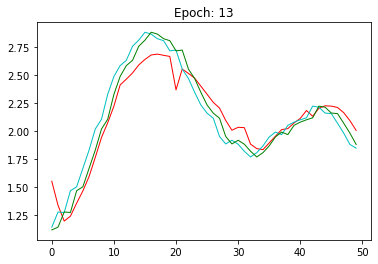

tensor([1.7401, 1.7254, 1.6607, 1.7872, 1.9117, 2.1004, 2.2614, 2.3780, 2.4874,
        2.5706, 2.4202, 2.6235, 2.6825, 2.7024, 2.7151, 2.7038, 2.6733, 2.6367,
        2.6090, 2.5511, 2.2718, 2.3432, 2.2636, 2.1981, 2.0857, 2.0573, 2.0105,
        1.9758, 1.9176, 1.9169, 1.9715, 1.9892, 1.9147, 1.9512, 2.0165, 2.0931,
        2.1597, 2.1729, 2.1943, 2.1993, 2.1840, 2.2378, 2.1804, 2.1329, 2.0601,
        2.0035, 1.8973, 1.8036, 1.6851, 1.6145])
target :  tensor([1.5932, 1.7008, 1.8263, 1.9502, 2.1532, 2.3215, 2.4251, 2.5748, 2.6799,
        2.8001, 2.8225, 2.8877, 2.8829, 2.8806, 2.8296, 2.7564, 2.6864, 2.6489,
        2.5304, 2.4006, 2.2826, 2.2094, 2.0933, 1.9574, 1.9564, 1.9146, 1.8786,
        1.8130, 1.8519, 1.7832, 1.8519, 1.9018, 1.9175, 2.0162, 2.0617, 2.1431,
        2.1065, 2.1454, 2.1333, 2.1995, 2.1399, 2.1495, 2.0372, 1.9617, 1.8806,
        1.7692, 1.6805, 1.5681, 1.5346, 1.4345])
 inputs:  tensor([1.5932, 1.7008, 1.8263, 1.9502, 2.1532, 2.3215, 2.4251, 2.5748, 2.6799,
  

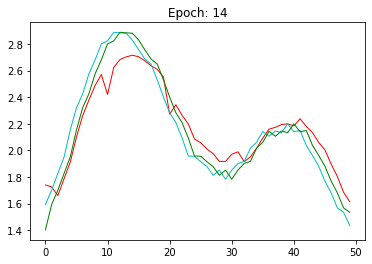

tensor([2.0644, 1.9806, 1.8057, 1.7327, 1.6142, 1.4796, 1.3910, 1.3089, 1.2332,
        1.1973, 1.5202, 1.2596, 1.0748, 1.1846, 1.2645, 1.3872, 1.4805, 1.6359,
        1.8157, 1.9577, 2.1484, 2.2869, 2.3774, 2.5002, 2.5783, 2.6467, 2.6744,
        2.7071, 2.7306, 2.7353, 2.4466, 2.6124, 2.6004, 2.5681, 2.5066, 2.4441,
        2.3511, 2.3061, 2.1980, 2.1361, 2.0471, 2.0075, 1.8548, 1.8616, 1.8810,
        1.9061, 1.9232, 1.9310, 1.9627, 2.0261])
target :  tensor([1.7933, 1.7519, 1.6430, 1.5400, 1.3583, 1.3477, 1.2463, 1.2032, 1.1781,
        1.1076, 1.0847, 1.1548, 1.2523, 1.3336, 1.4291, 1.5161, 1.6844, 1.8672,
        1.9738, 2.1265, 2.2638, 2.4912, 2.6220, 2.6939, 2.7871, 2.8073, 2.8721,
        2.9107, 2.9029, 2.8593, 2.7696, 2.6809, 2.6011, 2.4791, 2.3766, 2.2472,
        2.2256, 2.0608, 2.0309, 1.9301, 1.8465, 1.8051, 1.8150, 1.8587, 1.8400,
        1.8767, 1.8630, 1.9196, 1.9953, 2.0839])
 inputs:  tensor([1.7933, 1.7519, 1.6430, 1.5400, 1.3583, 1.3477, 1.2463, 1.2032, 1.1781,
  

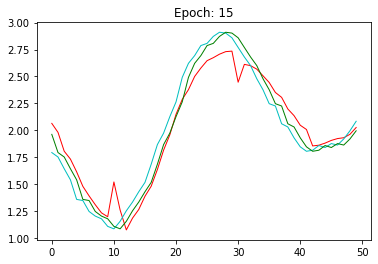

tensor([2.1347, 2.1987, 2.0750, 2.0018, 1.9362, 1.8610, 1.7440, 1.6289, 1.5307,
        1.4276, 1.6208, 1.3403, 1.1177, 1.0767, 1.0574, 1.1100, 1.1271, 1.1779,
        1.2168, 1.3580, 1.7631, 1.7217, 1.6921, 1.8795, 2.0524, 2.2332, 2.3690,
        2.4539, 2.5416, 2.6051, 2.4263, 2.6116, 2.6531, 2.6680, 2.6776, 2.6476,
        2.5825, 2.5212, 2.4702, 2.4227, 2.2227, 2.2280, 2.0895, 2.0559, 1.9621,
        1.9084, 1.8743, 1.8369, 1.8035, 1.8392])
target :  tensor([2.1749, 2.0680, 1.9586, 1.9117, 1.7929, 1.6833, 1.5667, 1.4987, 1.3933,
        1.2988, 1.1917, 1.2193, 1.1021, 1.1361, 1.1625, 1.1934, 1.2393, 1.2814,
        1.4638, 1.5068, 1.6429, 1.8089, 1.9943, 2.1622, 2.3381, 2.4877, 2.5628,
        2.6999, 2.7834, 2.8430, 2.8509, 2.8863, 2.8841, 2.8764, 2.7814, 2.6497,
        2.5600, 2.4971, 2.4338, 2.3309, 2.1735, 2.0726, 2.0374, 1.9167, 1.8527,
        1.8539, 1.8001, 1.7803, 1.8513, 1.8408])
 inputs:  tensor([2.1749, 2.0680, 1.9586, 1.9117, 1.7929, 1.6833, 1.5667, 1.4987, 1.3933,
  

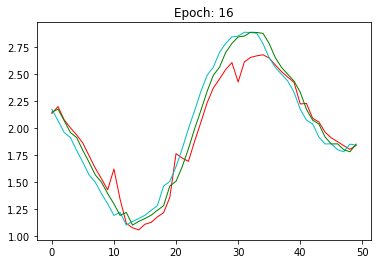

tensor([1.9986, 1.9929, 1.9169, 1.9434, 2.0175, 2.0702, 2.1016, 2.1913, 2.2260,
        2.2653, 2.1712, 2.2219, 2.1558, 2.1602, 2.0848, 2.0592, 1.9518, 1.8334,
        1.7216, 1.5866, 1.7121, 1.4873, 1.2268, 1.1882, 1.1411, 1.1468, 1.1256,
        1.1519, 1.1803, 1.2680, 1.7465, 1.6846, 1.6268, 1.8265, 1.9830, 2.1574,
        2.2902, 2.3899, 2.4934, 2.5774, 2.4397, 2.6276, 2.6971, 2.7226, 2.7350,
        2.7117, 2.6956, 2.6634, 2.5981, 2.5521])
target :  tensor([1.8651, 1.9189, 1.9032, 2.0148, 2.0110, 2.0537, 2.1739, 2.1798, 2.2271,
        2.1639, 2.1337, 2.1354, 2.1113, 1.9893, 1.9645, 1.8266, 1.7056, 1.6133,
        1.4771, 1.4080, 1.3114, 1.2538, 1.1757, 1.1538, 1.1322, 1.1282, 1.1598,
        1.1946, 1.3010, 1.4573, 1.5605, 1.6901, 1.8891, 2.0134, 2.1767, 2.3128,
        2.4095, 2.5550, 2.6637, 2.7849, 2.7851, 2.8973, 2.8983, 2.8868, 2.8097,
        2.7902, 2.7220, 2.5938, 2.5408, 2.3458])
 inputs:  tensor([1.8651, 1.9189, 1.9032, 2.0148, 2.0110, 2.0537, 2.1739, 2.1798, 2.2271,
  

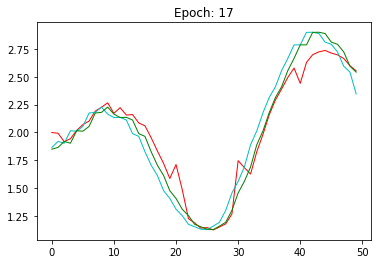

tensor([1.5725, 1.3236, 1.0654, 1.0896, 1.0567, 1.1131, 1.1830, 1.2497, 1.3824,
        1.5374, 1.8596, 1.9367, 1.9293, 2.1136, 2.2737, 2.3697, 2.5054, 2.5736,
        2.6277, 2.6875, 2.4706, 2.6593, 2.6729, 2.6684, 2.6594, 2.6229, 2.5771,
        2.4906, 2.4420, 2.3666, 2.1454, 2.1601, 2.0228, 1.9945, 1.9374, 1.8926,
        1.8668, 1.8418, 1.8272, 1.8846, 2.0049, 2.0163, 1.9403, 2.0107, 2.0729,
        2.1705, 2.2040, 2.1888, 2.2194, 2.1962])
target :  tensor([1.1995, 1.1383, 1.1309, 1.0861, 1.1434, 1.2318, 1.2791, 1.4433, 1.5861,
        1.6551, 1.8869, 1.9924, 2.1931, 2.3447, 2.3985, 2.6207, 2.6704, 2.7498,
        2.8573, 2.8839, 2.8700, 2.8339, 2.8087, 2.7706, 2.6805, 2.6096, 2.4578,
        2.4225, 2.3074, 2.1372, 2.0763, 1.9961, 1.9523, 1.8870, 1.8123, 1.8207,
        1.7808, 1.7822, 1.8695, 1.8872, 1.9272, 1.9646, 2.0209, 2.0798, 2.1698,
        2.1823, 2.1332, 2.2025, 2.1384, 2.1468])
 inputs:  tensor([1.1995, 1.1383, 1.1309, 1.0861, 1.1434, 1.2318, 1.2791, 1.4433, 1.5861,
  

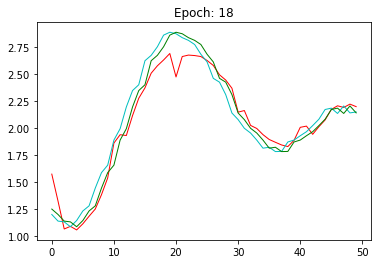

tensor([2.1242, 2.1314, 1.9916, 1.9049, 1.8475, 1.8890, 1.8771, 1.8873, 1.9383,
        1.9469, 2.0521, 2.0861, 2.0146, 2.1194, 2.1313, 2.2023, 2.2491, 2.2616,
        2.2172, 2.1793, 2.1010, 2.1296, 1.9421, 1.8918, 1.8047, 1.7374, 1.6214,
        1.4505, 1.3634, 1.2915, 1.5012, 1.2215, 1.0102, 1.0742, 1.1242, 1.1963,
        1.3051, 1.3952, 1.5214, 1.6467, 1.9970, 2.0541, 2.0584, 2.2291, 2.3773,
        2.4890, 2.5977, 2.6673, 2.6828, 2.7332])
target :  tensor([2.0304, 1.9621, 1.8253, 1.7998, 1.8423, 1.8197, 1.8315, 1.9085, 1.8858,
        1.9595, 1.9983, 2.0234, 2.1404, 2.0926, 2.1788, 2.2259, 2.2157, 2.1390,
        2.1066, 2.0441, 2.0397, 1.8878, 1.8366, 1.7391, 1.6493, 1.5402, 1.3507,
        1.3262, 1.2503, 1.1662, 1.1061, 1.1134, 1.1207, 1.1776, 1.2103, 1.3542,
        1.4061, 1.5538, 1.6555, 1.8679, 1.9785, 2.1095, 2.2936, 2.4428, 2.5440,
        2.7129, 2.7963, 2.7880, 2.9044, 2.9132])
 inputs:  tensor([2.0304, 1.9621, 1.8253, 1.7998, 1.8423, 1.8197, 1.8315, 1.9085, 1.8858,
  

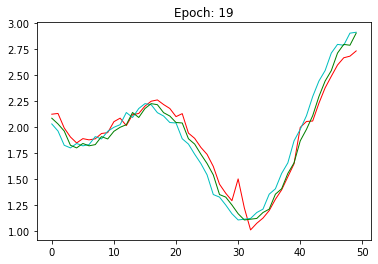

tensor([1.9507, 1.8078, 1.6094, 1.5610, 1.4109, 1.3352, 1.2602, 1.1770, 1.1305,
        1.0773, 1.4757, 1.2683, 1.1063, 1.2103, 1.3286, 1.5019, 1.6338, 1.8339,
        1.9498, 2.0856, 2.2510, 2.4100, 2.4332, 2.5482, 2.6323, 2.6975, 2.7123,
        2.7130, 2.7129, 2.6909, 2.4360, 2.5739, 2.5170, 2.4512, 2.3964, 2.3544,
        2.2379, 2.1303, 2.0769, 2.0244, 2.0002, 1.9551, 1.7800, 1.8176, 1.8408,
        1.8640, 1.9225, 1.9792, 2.0068, 2.0499])
target :  tensor([1.6795, 1.6490, 1.5496, 1.3833, 1.3034, 1.2589, 1.1573, 1.1444, 1.0785,
        1.1638, 1.2085, 1.2382, 1.2886, 1.4100, 1.5544, 1.6723, 1.8884, 1.9566,
        2.1125, 2.3408, 2.4588, 2.5254, 2.6956, 2.7806, 2.8626, 2.8610, 2.8551,
        2.8555, 2.8042, 2.7554, 2.6825, 2.5679, 2.4580, 2.3878, 2.3202, 2.1584,
        2.0474, 2.0252, 1.9650, 1.8931, 1.8599, 1.7934, 1.8336, 1.8452, 1.8279,
        1.9242, 1.9623, 1.9827, 2.0327, 2.1219])
 inputs:  tensor([1.6795, 1.6490, 1.5496, 1.3833, 1.3034, 1.2589, 1.1573, 1.1444, 1.0785,
  

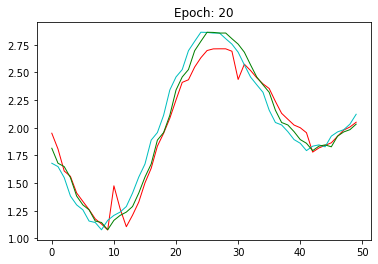

tensor([1.5408, 1.3596, 1.2603, 1.4771, 1.6709, 1.8198, 2.0085, 2.1855, 2.2973,
        2.4449, 2.3925, 2.6079, 2.6378, 2.6967, 2.7509, 2.7655, 2.7631, 2.7251,
        2.6829, 2.6734, 2.4003, 2.4892, 2.3878, 2.3374, 2.2404, 2.2017, 2.1345,
        2.0405, 1.9762, 1.9101, 1.9770, 1.9497, 1.8102, 1.8669, 1.9403, 1.9810,
        2.0301, 2.1270, 2.1894, 2.2174, 2.1997, 2.2426, 2.1623, 2.2082, 2.1883,
        2.1481, 2.0826, 1.9999, 1.9052, 1.8002])
target :  tensor([1.2745, 1.3779, 1.5504, 1.7121, 1.7988, 2.0243, 2.1875, 2.2853, 2.4876,
        2.5914, 2.7239, 2.7446, 2.8419, 2.9059, 2.8969, 2.8857, 2.7995, 2.7296,
        2.7354, 2.6092, 2.4839, 2.3549, 2.2920, 2.1533, 2.1158, 2.0422, 1.9280,
        1.8870, 1.8167, 1.8282, 1.8349, 1.8101, 1.8557, 1.9277, 1.9120, 1.9882,
        2.0974, 2.1477, 2.1607, 2.1998, 2.1599, 2.1479, 2.1944, 2.1298, 2.0521,
        1.9915, 1.8934, 1.8041, 1.6985, 1.6516])
 inputs:  tensor([1.2745, 1.3779, 1.5504, 1.7121, 1.7988, 2.0243, 2.1875, 2.2853, 2.4876,
  

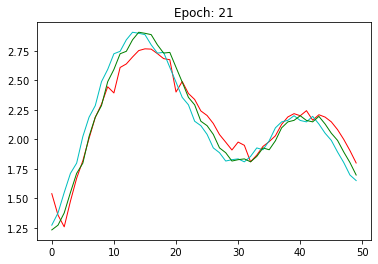

tensor([1.6205, 1.3005, 1.0793, 1.0757, 1.0534, 1.1056, 1.1197, 1.2175, 1.2729,
        1.4255, 1.8026, 1.7755, 1.7922, 1.9743, 2.1390, 2.2953, 2.3888, 2.4937,
        2.6028, 2.6656, 2.5041, 2.7082, 2.7310, 2.7192, 2.7129, 2.6765, 2.6479,
        2.6019, 2.5446, 2.4570, 2.2354, 2.2757, 2.1476, 2.0631, 1.9576, 1.9637,
        1.8954, 1.8663, 1.8953, 1.8856, 1.9539, 1.9698, 1.8956, 1.9822, 2.0753,
        2.1651, 2.2038, 2.2459, 2.2360, 2.2515])
target :  tensor([1.1857, 1.1989, 1.0976, 1.0909, 1.1151, 1.1396, 1.2486, 1.2845, 1.4670,
        1.5952, 1.6997, 1.8910, 2.0184, 2.1696, 2.3098, 2.4029, 2.5418, 2.6993,
        2.7679, 2.8694, 2.8989, 2.8920, 2.8538, 2.8217, 2.7361, 2.7012, 2.6217,
        2.5373, 2.4075, 2.2787, 2.2123, 2.1235, 2.0012, 1.8907, 1.9100, 1.8205,
        1.8059, 1.8611, 1.8258, 1.8110, 1.8913, 1.9300, 1.9937, 2.0796, 2.1383,
        2.1708, 2.2152, 2.1827, 2.2149, 2.1435])
 inputs:  tensor([1.1857, 1.1989, 1.0976, 1.0909, 1.1151, 1.1396, 1.2486, 1.2845, 1.4670,
  

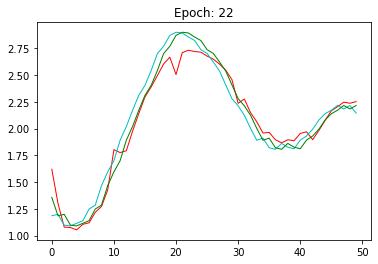

tensor([1.4018, 1.2409, 1.1231, 1.2297, 1.3812, 1.5422, 1.6797, 1.8268, 1.9706,
        2.1738, 2.2710, 2.4291, 2.4629, 2.5913, 2.6674, 2.7139, 2.7329, 2.7435,
        2.7336, 2.7100, 2.4840, 2.6083, 2.5532, 2.4892, 2.4062, 2.3323, 2.2560,
        2.1692, 2.0803, 1.9875, 1.9825, 1.9268, 1.8163, 1.8624, 1.8324, 1.8997,
        1.9608, 1.9675, 2.0469, 2.0686, 2.1092, 2.1981, 2.1461, 2.1900, 2.2171,
        2.1993, 2.2109, 2.1491, 2.0690, 2.0134])
target :  tensor([1.2163, 1.2575, 1.2881, 1.4432, 1.5536, 1.6886, 1.8228, 1.9656, 2.1979,
        2.3396, 2.4452, 2.5352, 2.7216, 2.7779, 2.8257, 2.8487, 2.8629, 2.8350,
        2.7903, 2.7991, 2.6797, 2.5875, 2.4874, 2.3626, 2.2603, 2.1865, 2.0812,
        1.9958, 1.8995, 1.8563, 1.8212, 1.8518, 1.8586, 1.7936, 1.8672, 1.9328,
        1.9053, 2.0278, 2.0127, 2.0545, 2.1476, 2.1611, 2.1877, 2.1965, 2.1295,
        2.1735, 2.0635, 1.9867, 1.9395, 1.8660])
 inputs:  tensor([1.2163, 1.2575, 1.2881, 1.4432, 1.5536, 1.6886, 1.8228, 1.9656, 2.1979,
  

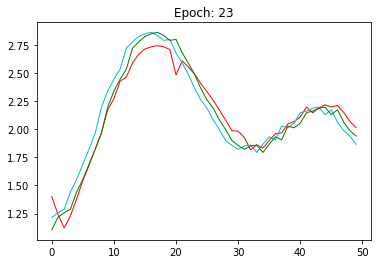

tensor([2.0954, 2.0645, 1.8606, 1.7635, 1.6701, 1.5364, 1.4144, 1.3591, 1.2794,
        1.2225, 1.4263, 1.1551, 0.9578, 1.0839, 1.1831, 1.3155, 1.3830, 1.5606,
        1.6907, 1.8506, 2.0432, 2.2022, 2.2416, 2.3888, 2.5366, 2.6260, 2.6768,
        2.7326, 2.7363, 2.7717, 2.4943, 2.7061, 2.6713, 2.6332, 2.5654, 2.5260,
        2.4330, 2.3448, 2.2661, 2.1383, 2.0778, 2.0474, 1.8419, 1.8526, 1.8318,
        1.8842, 1.9043, 1.9074, 1.9211, 1.9800])
target :  tensor([1.9640, 1.8452, 1.7201, 1.6372, 1.4517, 1.3784, 1.3285, 1.2519, 1.2025,
        1.1491, 1.1089, 1.0930, 1.1574, 1.2333, 1.3337, 1.3875, 1.5910, 1.6826,
        1.8532, 1.9565, 2.1846, 2.2993, 2.4580, 2.6236, 2.7038, 2.7711, 2.8666,
        2.8443, 2.9254, 2.8209, 2.8781, 2.7543, 2.7016, 2.5702, 2.5188, 2.3801,
        2.2791, 2.1973, 2.0394, 2.0107, 1.9480, 1.8285, 1.8478, 1.8011, 1.8447,
        1.8623, 1.8516, 1.8759, 1.9484, 2.0417])
 inputs:  tensor([1.9640, 1.8452, 1.7201, 1.6372, 1.4517, 1.3784, 1.3285, 1.2519, 1.2025,
  

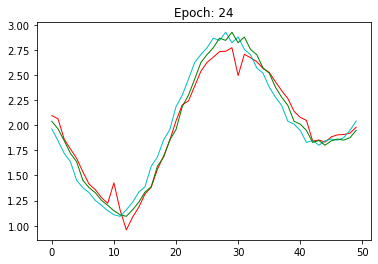

tensor([2.1763, 2.1996, 2.1130, 2.1788, 2.1437, 2.1855, 2.1419, 2.0503, 1.9810,
        1.8673, 1.8752, 1.6903, 1.4380, 1.3894, 1.3045, 1.2336, 1.1659, 1.1035,
        1.1051, 1.1187, 1.4332, 1.2144, 1.1100, 1.3540, 1.4820, 1.6700, 1.8610,
        2.0268, 2.1763, 2.2759, 2.3077, 2.4876, 2.5507, 2.6396, 2.7053, 2.7421,
        2.7416, 2.7529, 2.7051, 2.6557, 2.4375, 2.5459, 2.4842, 2.3993, 2.3378,
        2.2420, 2.1662, 2.0425, 1.9842, 1.9301])
target :  tensor([2.1469, 2.1475, 2.2168, 2.1179, 2.1740, 2.0989, 1.9874, 1.9352, 1.8043,
        1.7281, 1.5930, 1.5114, 1.4118, 1.3214, 1.2111, 1.1780, 1.0978, 1.1350,
        1.1340, 1.1783, 1.1982, 1.2790, 1.4624, 1.5206, 1.7014, 1.8914, 2.0393,
        2.1950, 2.2863, 2.4208, 2.5525, 2.6847, 2.7983, 2.8589, 2.8957, 2.8803,
        2.9079, 2.7990, 2.7260, 2.6897, 2.6021, 2.5346, 2.4027, 2.3304, 2.1814,
        2.1266, 1.9680, 1.9490, 1.8831, 1.8450])
 inputs:  tensor([2.1469, 2.1475, 2.2168, 2.1179, 2.1740, 2.0989, 1.9874, 1.9352, 1.8043,
  

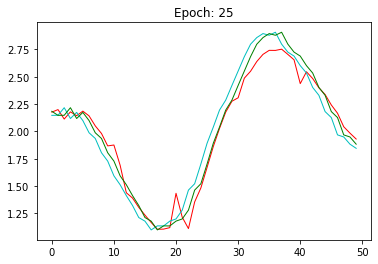

tensor([1.3941, 1.1043, 0.9742, 1.1652, 1.2393, 1.3672, 1.4967, 1.6455, 1.8099,
        2.0076, 2.1440, 2.2741, 2.3209, 2.4393, 2.5948, 2.6758, 2.7242, 2.7131,
        2.7310, 2.7528, 2.5180, 2.6564, 2.5964, 2.5150, 2.4765, 2.4313, 2.2961,
        2.2268, 2.1628, 2.0590, 2.0070, 1.9277, 1.7842, 1.7832, 1.8280, 1.8726,
        1.8984, 1.9657, 1.9597, 2.0032, 2.0985, 2.1674, 2.1287, 2.1483, 2.1894,
        2.1910, 2.1997, 2.1413, 2.1057, 2.0301])
target :  tensor([1.0833, 1.1459, 1.2506, 1.2712, 1.3876, 1.5201, 1.6570, 1.8225, 2.0288,
        2.1293, 2.2705, 2.4123, 2.5320, 2.7315, 2.7987, 2.8706, 2.8276, 2.8753,
        2.9124, 2.8690, 2.7795, 2.6728, 2.5538, 2.5056, 2.4227, 2.2373, 2.1900,
        2.1207, 1.9948, 1.9176, 1.8424, 1.8391, 1.7908, 1.8441, 1.8384, 1.8805,
        1.9492, 1.9198, 1.9861, 2.0567, 2.1317, 2.1818, 2.1605, 2.2007, 2.1545,
        2.1850, 2.0865, 2.0717, 1.9717, 1.9404])
 inputs:  tensor([1.0833, 1.1459, 1.2506, 1.2712, 1.3876, 1.5201, 1.6570, 1.8225, 2.0288,
  

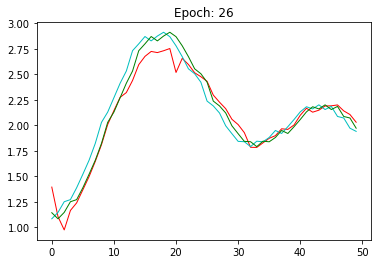

tensor([1.9775, 2.0789, 2.1387, 2.2678, 2.4261, 2.5683, 2.6377, 2.6730, 2.7115,
        2.7452, 2.5629, 2.7330, 2.7419, 2.7075, 2.6603, 2.5760, 2.4969, 2.4217,
        2.3319, 2.2656, 2.1516, 2.1353, 1.9595, 1.8702, 1.8908, 1.8550, 1.8823,
        1.8566, 1.9068, 1.9849, 2.0297, 2.0988, 2.0416, 2.0942, 2.1303, 2.2009,
        2.2168, 2.2022, 2.1983, 2.2089, 2.1025, 2.0689, 1.9080, 1.8763, 1.7468,
        1.6639, 1.5751, 1.4526, 1.3133, 1.2533])
target :  tensor([2.0281, 2.2052, 2.2937, 2.4698, 2.6230, 2.6974, 2.7396, 2.8049, 2.8560,
        2.9210, 2.8693, 2.8737, 2.8084, 2.7043, 2.5608, 2.4697, 2.3751, 2.2673,
        2.2027, 2.1113, 2.0385, 1.9492, 1.8285, 1.8819, 1.7720, 1.8513, 1.7824,
        1.8764, 1.9430, 1.9264, 2.0348, 2.0653, 2.0905, 2.1037, 2.1632, 2.1682,
        2.1402, 2.1472, 2.1608, 2.0347, 1.9674, 1.9126, 1.8520, 1.6868, 1.5952,
        1.5267, 1.3874, 1.2655, 1.2302, 1.1739])
 inputs:  tensor([2.0281, 2.2052, 2.2937, 2.4698, 2.6230, 2.6974, 2.7396, 2.8049, 2.8560,
  

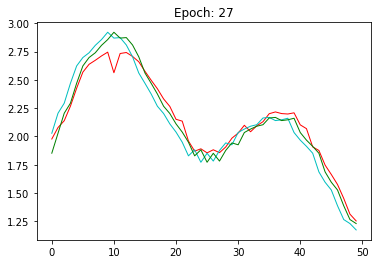

tensor([1.3887, 1.1032, 1.0276, 1.1472, 1.2545, 1.4097, 1.5715, 1.7217, 1.8786,
        2.0460, 2.1964, 2.3346, 2.3907, 2.4924, 2.5773, 2.6643, 2.7251, 2.7543,
        2.7860, 2.7824, 2.5366, 2.6617, 2.6050, 2.5820, 2.5377, 2.4680, 2.3632,
        2.2194, 2.1527, 2.0549, 2.0603, 1.9555, 1.8331, 1.8459, 1.8220, 1.8767,
        1.9320, 1.9868, 1.9880, 2.0578, 2.1409, 2.1396, 2.1256, 2.1459, 2.1587,
        2.2154, 2.2378, 2.1852, 2.1142, 2.0806])
target :  tensor([1.0856, 1.2046, 1.1900, 1.2914, 1.4096, 1.5791, 1.7012, 1.8651, 2.0291,
        2.1795, 2.3111, 2.4614, 2.5589, 2.6360, 2.7457, 2.8307, 2.8642, 2.9206,
        2.8997, 2.8359, 2.7330, 2.6537, 2.6386, 2.5447, 2.4316, 2.3063, 2.1332,
        2.0986, 1.9768, 1.9710, 1.8443, 1.8798, 1.8389, 1.7953, 1.8354, 1.9016,
        1.9408, 1.9321, 2.0284, 2.0918, 2.0548, 2.1763, 2.1345, 2.1351, 2.1797,
        2.2017, 2.1129, 2.0477, 2.0251, 1.9537])
 inputs:  tensor([1.0856, 1.2046, 1.1900, 1.2914, 1.4096, 1.5791, 1.7012, 1.8651, 2.0291,
  

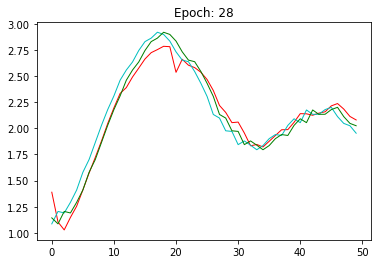

tensor([2.2434, 2.2385, 2.0558, 1.9856, 1.9593, 1.9545, 1.9195, 1.8963, 1.8357,
        1.8520, 1.9531, 1.9938, 1.9307, 2.0156, 2.0712, 2.1343, 2.1691, 2.2113,
        2.2351, 2.2281, 2.1857, 2.1862, 2.0274, 1.9745, 1.9757, 1.8896, 1.8052,
        1.6356, 1.5498, 1.4139, 1.4950, 1.2270, 1.0184, 1.0938, 1.0674, 1.1000,
        1.1231, 1.2298, 1.3018, 1.3845, 1.7656, 1.7147, 1.7476, 1.9803, 2.1814,
        2.3065, 2.4015, 2.5039, 2.6358, 2.6812])
target :  tensor([2.1631, 2.0476, 1.9680, 1.9421, 1.9004, 1.8737, 1.8454, 1.7812, 1.8209,
        1.8294, 1.9393, 1.9781, 2.0342, 2.0574, 2.0986, 2.1369, 2.1802, 2.2020,
        2.1848, 2.1681, 2.1108, 2.0314, 1.9600, 1.9645, 1.8088, 1.7603, 1.5587,
        1.5259, 1.3607, 1.2745, 1.1990, 1.1593, 1.1487, 1.0795, 1.0998, 1.1301,
        1.2450, 1.2963, 1.3829, 1.5892, 1.6646, 1.8622, 2.0302, 2.2008, 2.2896,
        2.4093, 2.5363, 2.7272, 2.7559, 2.7854])
 inputs:  tensor([2.1631, 2.0476, 1.9680, 1.9421, 1.9004, 1.8737, 1.8454, 1.7812, 1.8209,
  

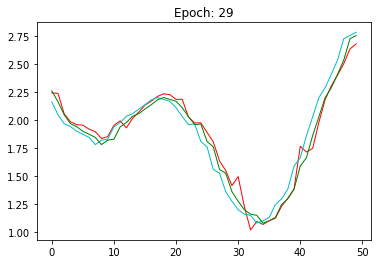

tensor([1.7546, 1.6898, 1.6793, 1.9205, 2.1199, 2.2775, 2.4421, 2.5197, 2.5991,
        2.6743, 2.5119, 2.7156, 2.7277, 2.7182, 2.7179, 2.7085, 2.6188, 2.5673,
        2.4996, 2.4195, 2.2470, 2.2599, 2.0503, 1.9677, 1.9390, 1.9405, 1.8952,
        1.8580, 1.8661, 1.8254, 1.9757, 1.9495, 1.8842, 1.9629, 2.0461, 2.0967,
        2.1133, 2.2067, 2.2270, 2.2416, 2.1483, 2.1498, 2.0336, 1.9768, 1.9281,
        1.8617, 1.7138, 1.6577, 1.5315, 1.4320])
target :  tensor([1.6566, 1.8016, 1.9919, 2.1476, 2.2827, 2.4947, 2.5567, 2.6745, 2.7818,
        2.7890, 2.8692, 2.8747, 2.8649, 2.8362, 2.8083, 2.6509, 2.6018, 2.5075,
        2.4057, 2.2836, 2.2109, 2.0474, 1.9694, 1.9396, 1.9059, 1.8621, 1.8223,
        1.8489, 1.7848, 1.8781, 1.8940, 1.9594, 1.9952, 2.0585, 2.0668, 2.0924,
        2.2101, 2.2033, 2.2240, 2.1264, 2.0933, 2.0710, 1.9756, 1.9196, 1.8116,
        1.6691, 1.6376, 1.4942, 1.4138, 1.2779])
 inputs:  tensor([1.6566, 1.8016, 1.9919, 2.1476, 2.2827, 2.4947, 2.5567, 2.6745, 2.7818,
  

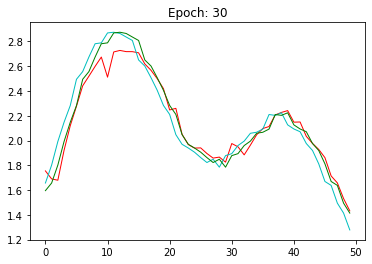

tensor([2.4842, 2.5666, 2.4741, 2.3728, 2.2809, 2.2484, 2.1641, 2.0529, 2.0148,
        1.9152, 1.9270, 1.8536, 1.7386, 1.8382, 1.8702, 1.9572, 1.9741, 2.0503,
        2.1063, 2.1604, 2.1526, 2.2166, 2.1480, 2.1482, 2.1669, 2.1438, 2.1290,
        2.0903, 1.9796, 1.8595, 1.8818, 1.6934, 1.4650, 1.3835, 1.2862, 1.2254,
        1.1728, 1.1420, 1.1024, 1.1484, 1.3905, 1.1982, 1.1882, 1.3453, 1.5626,
        1.7253, 1.8366, 2.0553, 2.1603, 2.3205])
target :  tensor([2.5751, 2.4845, 2.3589, 2.2421, 2.1999, 2.1002, 1.9755, 1.9677, 1.8392,
        1.8012, 1.7721, 1.7964, 1.8585, 1.8418, 1.9167, 1.9217, 2.0147, 2.0618,
        2.1195, 2.1176, 2.1573, 2.1650, 2.1405, 2.1456, 2.0778, 2.0832, 2.0259,
        1.9025, 1.7889, 1.7430, 1.5994, 1.5384, 1.3862, 1.2864, 1.1884, 1.1643,
        1.1174, 1.0872, 1.1470, 1.1768, 1.2039, 1.3536, 1.3794, 1.5929, 1.6870,
        1.8045, 2.0477, 2.1152, 2.3196, 2.4219])
 inputs:  tensor([2.5751, 2.4845, 2.3589, 2.2421, 2.1999, 2.1002, 1.9755, 1.9677, 1.8392,
  

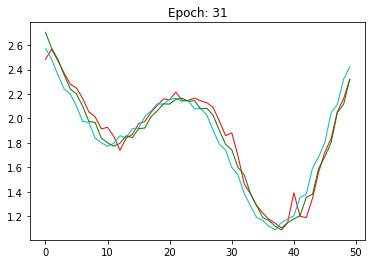

tensor([1.8518, 1.9096, 1.8997, 2.1381, 2.3143, 2.4313, 2.5377, 2.6247, 2.7141,
        2.7426, 2.5775, 2.7556, 2.7336, 2.7399, 2.7004, 2.6764, 2.5708, 2.4950,
        2.4548, 2.3134, 2.1780, 2.1696, 2.0418, 1.9297, 1.8756, 1.8686, 1.8406,
        1.8552, 1.8474, 1.8745, 2.0157, 1.9981, 1.9501, 2.0759, 2.1252, 2.2224,
        2.2527, 2.2248, 2.1968, 2.2126, 2.1842, 2.1693, 2.0029, 1.9492, 1.8849,
        1.8149, 1.6729, 1.5832, 1.4275, 1.3145])
target :  tensor([1.8597, 1.9535, 2.1865, 2.3144, 2.4188, 2.5635, 2.6731, 2.8060, 2.8291,
        2.8966, 2.8806, 2.8311, 2.8737, 2.7594, 2.7237, 2.5548, 2.4738, 2.4353,
        2.2363, 2.1504, 2.0819, 2.0498, 1.8915, 1.8495, 1.8084, 1.7897, 1.8024,
        1.7918, 1.8254, 1.9170, 1.9153, 1.9965, 2.0939, 2.0907, 2.1883, 2.2077,
        2.1614, 2.1421, 2.1711, 2.1598, 2.0796, 2.0013, 1.9310, 1.8471, 1.7419,
        1.6090, 1.5327, 1.3693, 1.2786, 1.2416])
 inputs:  tensor([1.8597, 1.9535, 2.1865, 2.3144, 2.4188, 2.5635, 2.6731, 2.8060, 2.8291,
  

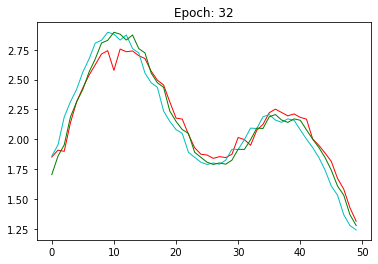

tensor([1.3004, 1.1008, 1.0407, 1.1875, 1.2999, 1.4611, 1.5416, 1.7248, 1.8849,
        2.0327, 2.1537, 2.2909, 2.3928, 2.4754, 2.6068, 2.6986, 2.7176, 2.7591,
        2.7643, 2.7575, 2.5148, 2.6884, 2.6176, 2.5668, 2.5086, 2.4481, 2.3324,
        2.2034, 2.1414, 2.0506, 1.9738, 1.9408, 1.7996, 1.8030, 1.8539, 1.8589,
        1.8793, 1.9651, 1.9948, 2.0486, 2.0756, 2.1085, 2.0730, 2.1500, 2.1824,
        2.1977, 2.1793, 2.1905, 2.1491, 2.0252])
target :  tensor([1.1356, 1.2052, 1.2339, 1.3170, 1.4525, 1.5167, 1.7209, 1.8607, 2.0099,
        2.1398, 2.2729, 2.4917, 2.5426, 2.7049, 2.8066, 2.8155, 2.8963, 2.8911,
        2.8781, 2.7867, 2.7958, 2.6806, 2.6375, 2.5311, 2.4396, 2.2953, 2.1520,
        2.1097, 1.9978, 1.8856, 1.8760, 1.8502, 1.8169, 1.8567, 1.8058, 1.8541,
        1.9411, 1.9539, 2.0191, 2.0255, 2.0533, 2.1266, 2.1783, 2.1715, 2.1617,
        2.1468, 2.1633, 2.1043, 1.9599, 1.9494])
 inputs:  tensor([1.1356, 1.2052, 1.2339, 1.3170, 1.4525, 1.5167, 1.7209, 1.8607, 2.0099,
  

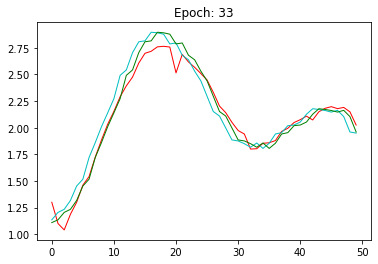

tensor([3.2448, 1.4562, 1.1240, 1.3884, 1.5195, 1.7662, 1.8578, 2.0131, 2.1493,
        2.3374, 2.3352, 2.5209, 2.5626, 2.6595, 2.7398, 2.7573, 2.7919, 2.7586,
        2.7543, 2.7135, 2.4760, 2.5565, 2.4624, 2.3718, 2.3359, 2.2491, 2.1525,
        2.0849, 2.0220, 1.9266, 1.9635, 1.8725, 1.7481, 1.8590, 1.8597, 1.9118,
        1.9571, 2.0153, 2.1177, 2.1906, 2.1740, 2.2584, 2.1916, 2.1920, 2.2094,
        2.1633, 2.1430, 2.0772, 1.9849, 1.9001])
target :  tensor([1.1861, 1.3091, 1.4325, 1.5383, 1.6897, 1.8420, 1.9599, 2.1222, 2.3309,
        2.4240, 2.5378, 2.6360, 2.7831, 2.8558, 2.8540, 2.9239, 2.8464, 2.8537,
        2.7787, 2.6914, 2.5532, 2.4714, 2.3681, 2.3206, 2.1808, 2.0937, 2.0240,
        1.9629, 1.8552, 1.8650, 1.7821, 1.8009, 1.8802, 1.8166, 1.8612, 1.9131,
        1.9648, 2.0834, 2.1456, 2.1613, 2.2016, 2.2023, 2.1891, 2.1870, 2.0927,
        2.0982, 2.0065, 1.9176, 1.8361, 1.7390])
 inputs:  tensor([1.1861, 1.3091, 1.4325, 1.5383, 1.6897, 1.8420, 1.9599, 2.1222, 2.3309,
  

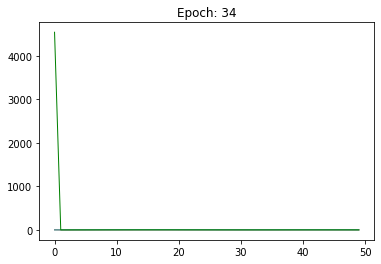

tensor([1.9366, 1.8900, 1.7874, 1.8418, 1.8558, 1.8717, 1.9195, 1.9998, 2.0182,
        2.0936, 2.0983, 2.1717, 2.1564, 2.1991, 2.2239, 2.1930, 2.1737, 2.1192,
        2.0900, 1.9594, 1.9028, 1.7787, 1.5812, 1.5285, 1.4398, 1.3848, 1.2323,
        1.1498, 1.1202, 1.1058, 1.3528, 1.1248, 1.1023, 1.2638, 1.4016, 1.6198,
        1.7315, 1.8829, 2.0028, 2.1423, 2.2708, 2.4248, 2.4715, 2.5764, 2.6609,
        2.7125, 2.7621, 2.7580, 2.7416, 2.7416])
target :  tensor([1.8108, 1.8368, 1.8504, 1.8263, 1.8141, 1.8838, 1.9555, 1.9592, 2.0569,
        2.0531, 2.1079, 2.1872, 2.2042, 2.1997, 2.1304, 2.1308, 2.0559, 2.0406,
        1.8787, 1.7912, 1.6929, 1.6401, 1.5358, 1.4275, 1.3440, 1.1957, 1.1287,
        1.1079, 1.0852, 1.1726, 1.1406, 1.2691, 1.2960, 1.4066, 1.5989, 1.6841,
        1.8462, 1.9575, 2.1092, 2.3172, 2.4065, 2.5316, 2.6696, 2.7396, 2.7969,
        2.8796, 2.8556, 2.8298, 2.8389, 2.7763])
 inputs:  tensor([1.8108, 1.8368, 1.8504, 1.8263, 1.8141, 1.8838, 1.9555, 1.9592, 2.0569,
  

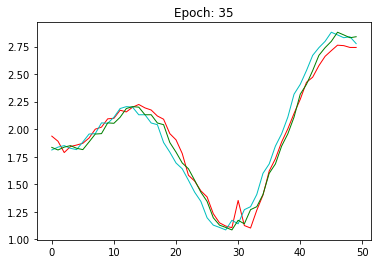

tensor([1.9548, 1.9997, 1.9351, 1.9422, 2.0406, 2.1301, 2.1340, 2.1987, 2.1866,
        2.2432, 2.1360, 2.1876, 2.0497, 2.0196, 1.9047, 1.8808, 1.7518, 1.6746,
        1.5392, 1.4425, 1.4554, 1.2053, 0.9939, 1.0919, 1.1275, 1.1151, 1.1925,
        1.2459, 1.3495, 1.4159, 1.7297, 1.6828, 1.7218, 1.9626, 2.1851, 2.2943,
        2.4206, 2.5055, 2.6335, 2.6940, 2.5430, 2.7215, 2.7347, 2.7488, 2.7218,
        2.6753, 2.6438, 2.5483, 2.5038, 2.3923])
target :  tensor([1.9504, 1.9819, 1.9525, 2.0508, 2.0992, 2.0936, 2.1816, 2.1457, 2.2313,
        2.1134, 2.1319, 2.0624, 2.0319, 1.8718, 1.8507, 1.7041, 1.6473, 1.5019,
        1.4276, 1.2927, 1.2143, 1.1434, 1.1614, 1.1466, 1.0968, 1.2139, 1.2326,
        1.3531, 1.3956, 1.5927, 1.6514, 1.8332, 2.0096, 2.1947, 2.2650, 2.4397,
        2.5278, 2.7167, 2.7806, 2.8363, 2.8318, 2.8639, 2.9138, 2.8162, 2.7384,
        2.7041, 2.5538, 2.5188, 2.3624, 2.2518])
 inputs:  tensor([1.9504, 1.9819, 1.9525, 2.0508, 2.0992, 2.0936, 2.1816, 2.1457, 2.2313,
  

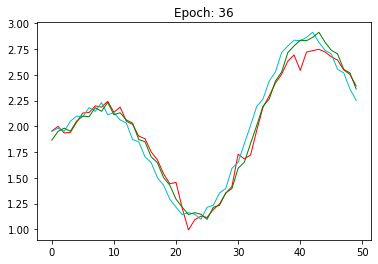

tensor([2.3957, 2.6445, 2.6503, 2.7089, 2.7731, 2.7820, 2.7375, 2.7186, 2.6836,
        2.6713, 2.4487, 2.5277, 2.4275, 2.3271, 2.1919, 2.1360, 2.0500, 2.0070,
        1.9198, 1.8719, 1.9291, 1.8675, 1.7837, 1.8805, 1.9066, 2.0097, 2.0711,
        2.1103, 2.1531, 2.1756, 2.1677, 2.2409, 2.1822, 2.1460, 2.1050, 2.0952,
        2.0840, 1.9700, 1.9029, 1.7836, 1.7599, 1.5876, 1.2960, 1.2631, 1.2450,
        1.2345, 1.1148, 1.0796, 1.1246, 1.2192])
target :  tensor([2.7223, 2.7275, 2.8529, 2.9110, 2.8983, 2.8183, 2.8045, 2.7460, 2.7356,
        2.6277, 2.5164, 2.4372, 2.3317, 2.1539, 2.0965, 2.0037, 1.9640, 1.8665,
        1.8327, 1.8303, 1.7976, 1.8485, 1.9063, 1.8803, 1.9789, 2.0338, 2.0655,
        2.1178, 2.1357, 2.1543, 2.1850, 2.2032, 2.1450, 2.0800, 2.0522, 2.0473,
        1.9009, 1.8649, 1.7289, 1.6268, 1.5344, 1.3844, 1.3116, 1.2634, 1.2100,
        1.0925, 1.0774, 1.1284, 1.2143, 1.2554])
 inputs:  tensor([2.7223, 2.7275, 2.8529, 2.9110, 2.8983, 2.8183, 2.8045, 2.7460, 2.7356,
  

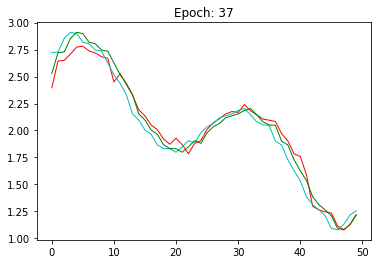

tensor([1.9501, 1.7853, 1.5251, 1.4527, 1.4047, 1.3676, 1.2520, 1.2008, 1.1172,
        1.1171, 1.2498, 1.0777, 1.0852, 1.2982, 1.4177, 1.6126, 1.7130, 1.8808,
        2.0740, 2.2032, 2.2771, 2.4405, 2.5364, 2.6121, 2.6827, 2.7299, 2.7555,
        2.7595, 2.7433, 2.7356, 2.5192, 2.6276, 2.5957, 2.4770, 2.4229, 2.3325,
        2.2202, 2.1750, 2.0440, 1.9752, 1.9918, 1.8920, 1.7513, 1.8197, 1.8941,
        1.9552, 1.9214, 1.9486, 2.0336, 2.1124])
target :  tensor([1.6908, 1.5810, 1.4726, 1.4059, 1.3241, 1.2207, 1.1777, 1.0889, 1.1046,
        1.0837, 1.1265, 1.2419, 1.3317, 1.3992, 1.5835, 1.6587, 1.8424, 2.0346,
        2.1525, 2.3076, 2.4160, 2.6120, 2.6959, 2.7552, 2.8123, 2.8479, 2.8501,
        2.8213, 2.8154, 2.7482, 2.6432, 2.6416, 2.4854, 2.4152, 2.2806, 2.1652,
        2.1289, 1.9715, 1.9244, 1.9000, 1.7990, 1.7987, 1.8372, 1.8715, 1.8942,
        1.8584, 1.9012, 1.9942, 2.0621, 2.0763])
 inputs:  tensor([1.6908, 1.5810, 1.4726, 1.4059, 1.3241, 1.2207, 1.1777, 1.0889, 1.1046,
  

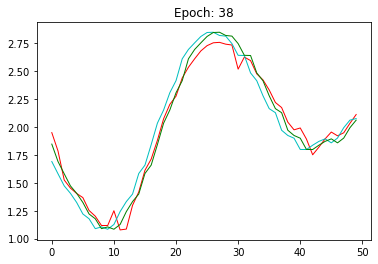

tensor([1.4641, 1.4448, 1.4318, 1.6954, 1.8434, 2.0271, 2.1917, 2.3336, 2.4564,
        2.5750, 2.4676, 2.6776, 2.7040, 2.7104, 2.7750, 2.7959, 2.7575, 2.6906,
        2.6785, 2.5673, 2.3819, 2.4615, 2.3352, 2.1910, 2.1109, 2.0323, 2.0000,
        1.9678, 1.8558, 1.8122, 1.9042, 1.8813, 1.7684, 1.8754, 1.9721, 2.0538,
        2.0747, 2.1297, 2.2120, 2.2408, 2.1907, 2.2680, 2.1503, 2.1506, 2.0982,
        2.0615, 1.9757, 1.8309, 1.7739, 1.6459])
target :  tensor([1.4638, 1.5398, 1.7397, 1.8082, 1.9903, 2.1590, 2.3083, 2.4528, 2.6066,
        2.6575, 2.7463, 2.7995, 2.8304, 2.9058, 2.9150, 2.8388, 2.7396, 2.7417,
        2.5594, 2.4979, 2.4253, 2.3243, 2.1743, 2.0884, 1.9753, 1.9649, 1.9153,
        1.7955, 1.7750, 1.8051, 1.8178, 1.8161, 1.9035, 1.9513, 2.0025, 2.0244,
        2.0897, 2.1803, 2.1942, 2.1888, 2.2081, 2.1466, 2.1625, 2.0611, 2.0090,
        1.9225, 1.7690, 1.7438, 1.5932, 1.5378])
 inputs:  tensor([1.4638, 1.5398, 1.7397, 1.8082, 1.9903, 2.1590, 2.3083, 2.4528, 2.6066,
  

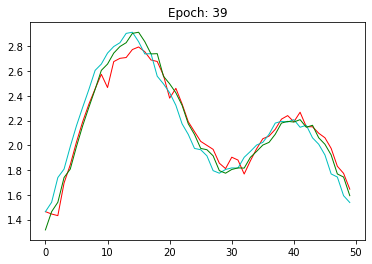

tensor([2.1789, 2.2523, 2.1806, 2.1400, 2.1297, 2.0925, 2.0713, 1.9797, 1.8606,
        1.7339, 1.7369, 1.5104, 1.2767, 1.2492, 1.1878, 1.2185, 1.1790, 1.1135,
        1.1018, 1.2088, 1.3977, 1.3045, 1.3168, 1.5006, 1.7202, 1.9269, 2.0349,
        2.1891, 2.3218, 2.4626, 2.4164, 2.6109, 2.6796, 2.7342, 2.7649, 2.7579,
        2.7697, 2.7467, 2.7027, 2.6394, 2.4554, 2.4967, 2.3983, 2.2567, 2.1982,
        2.1391, 2.0274, 1.9795, 1.9282, 1.9173])
target :  tensor([2.1848, 2.1840, 2.1333, 2.1032, 2.0313, 2.0269, 1.9112, 1.8046, 1.6835,
        1.6053, 1.4585, 1.3841, 1.2870, 1.1945, 1.2018, 1.1573, 1.0857, 1.0944,
        1.2054, 1.2486, 1.3325, 1.4478, 1.5264, 1.7109, 1.8754, 1.9745, 2.1524,
        2.2900, 2.4575, 2.5443, 2.6368, 2.7735, 2.8678, 2.8632, 2.8402, 2.8683,
        2.8220, 2.7528, 2.6637, 2.6166, 2.4518, 2.3966, 2.2406, 2.1770, 2.0819,
        1.9697, 1.9319, 1.8777, 1.8705, 1.8075])
 inputs:  tensor([2.1848, 2.1840, 2.1333, 2.1032, 2.0313, 2.0269, 1.9112, 1.8046, 1.6835,
  

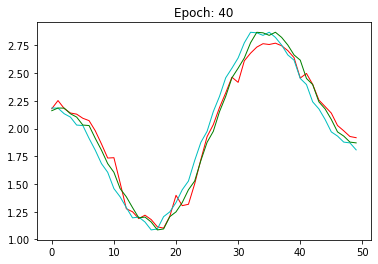

tensor([1.9510, 1.9395, 1.8724, 1.9303, 1.9744, 2.0316, 2.1084, 2.1514, 2.1893,
        2.2181, 2.1806, 2.2217, 2.1348, 2.0991, 2.0970, 2.0684, 1.9418, 1.8824,
        1.7628, 1.6309, 1.6465, 1.4524, 1.1993, 1.1451, 1.1557, 1.1506, 1.1739,
        1.1506, 1.2215, 1.2422, 1.4832, 1.4344, 1.4274, 1.6242, 1.8728, 2.0348,
        2.1671, 2.3519, 2.4487, 2.5883, 2.4972, 2.7032, 2.7472, 2.7237, 2.7930,
        2.7961, 2.7597, 2.7056, 2.6307, 2.5604])
target :  tensor([1.8662, 1.9091, 1.9359, 1.9412, 1.9752, 2.0660, 2.0928, 2.1394, 2.1685,
        2.1662, 2.1443, 2.1365, 2.0933, 2.0687, 2.0046, 1.8750, 1.8349, 1.7043,
        1.5826, 1.5109, 1.4198, 1.3014, 1.1817, 1.1735, 1.1141, 1.1626, 1.1123,
        1.2128, 1.2018, 1.3403, 1.4428, 1.5314, 1.6471, 1.8555, 1.9663, 2.1175,
        2.3321, 2.4215, 2.6189, 2.6999, 2.7701, 2.8540, 2.8331, 2.9263, 2.9009,
        2.8350, 2.7575, 2.6495, 2.5610, 2.4915])
 inputs:  tensor([1.8662, 1.9091, 1.9359, 1.9412, 1.9752, 2.0660, 2.0928, 2.1394, 2.1685,
  

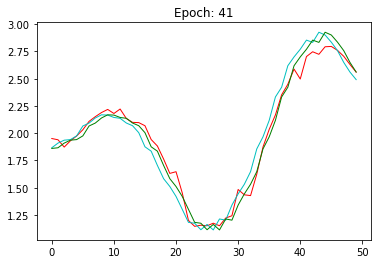

tensor([2.1301, 2.2448, 2.1710, 2.1934, 2.2094, 2.2203, 2.1791, 2.0834, 1.9943,
        1.8860, 1.8004, 1.6761, 1.4559, 1.3616, 1.3184, 1.2724, 1.2051, 1.1345,
        1.0982, 1.1547, 1.3470, 1.2380, 1.2130, 1.4271, 1.5864, 1.7690, 1.9492,
        2.0337, 2.2345, 2.3211, 2.3848, 2.5772, 2.6018, 2.6451, 2.7439, 2.8055,
        2.8120, 2.7607, 2.7307, 2.6864, 2.4894, 2.6286, 2.4919, 2.3763, 2.3104,
        2.2208, 2.1503, 2.1067, 1.9711, 1.9304])
target :  tensor([2.1793, 2.1585, 2.1937, 2.1713, 2.1612, 2.1160, 2.0094, 1.9321, 1.8212,
        1.6798, 1.6126, 1.5187, 1.3764, 1.3206, 1.2269, 1.1782, 1.0963, 1.0754,
        1.1325, 1.2058, 1.2714, 1.3339, 1.4525, 1.5514, 1.7107, 1.8911, 1.9537,
        2.2021, 2.2600, 2.4809, 2.5800, 2.6437, 2.7287, 2.8402, 2.9139, 2.9118,
        2.8249, 2.7918, 2.7242, 2.6730, 2.6374, 2.4664, 2.3747, 2.2822, 2.1557,
        2.0965, 2.0479, 1.8941, 1.8821, 1.8133])
 inputs:  tensor([2.1793, 2.1585, 2.1937, 2.1713, 2.1612, 2.1160, 2.0094, 1.9321, 1.8212,
  

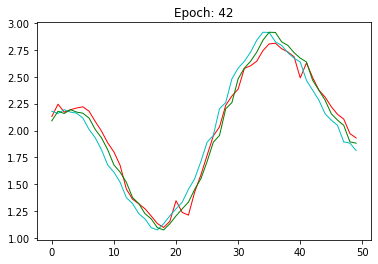

tensor([2.4508, 2.6306, 2.6972, 2.6749, 2.7301, 2.7697, 2.7606, 2.7506, 2.7246,
        2.6353, 2.4391, 2.5419, 2.4122, 2.2640, 2.2013, 2.1201, 2.0373, 1.9432,
        1.8938, 1.8732, 1.8941, 1.8985, 1.7681, 1.8579, 1.9311, 2.0144, 2.0793,
        2.0928, 2.1229, 2.1417, 2.1739, 2.2097, 2.1508, 2.1224, 2.1381, 2.1209,
        2.0511, 1.9903, 1.8745, 1.7657, 1.7597, 1.4987, 1.2536, 1.2416, 1.1782,
        1.2012, 1.1852, 1.1442, 1.1130, 1.1423])
target :  tensor([2.6816, 2.8176, 2.7911, 2.8521, 2.8990, 2.8697, 2.8608, 2.8187, 2.6783,
        2.6005, 2.5456, 2.4161, 2.2782, 2.2034, 2.0831, 2.0091, 1.9055, 1.8701,
        1.8439, 1.8070, 1.8543, 1.8164, 1.8996, 1.9182, 1.9779, 2.0491, 2.0506,
        2.0943, 2.1100, 2.1708, 2.1531, 2.1799, 2.1409, 2.1345, 2.0819, 2.0147,
        1.9551, 1.8348, 1.7357, 1.6520, 1.4610, 1.3784, 1.2980, 1.1919, 1.1921,
        1.1764, 1.1234, 1.1050, 1.1375, 1.2734])
 inputs:  tensor([2.6816, 2.8176, 2.7911, 2.8521, 2.8990, 2.8697, 2.8608, 2.8187, 2.6783,
  

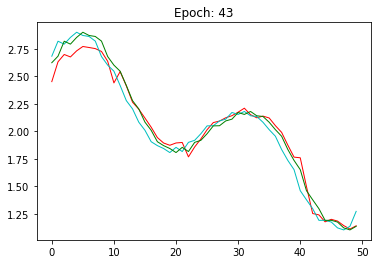

tensor([1.3482, 1.3186, 1.2940, 1.5407, 1.7016, 1.8515, 2.0757, 2.1751, 2.3668,
        2.4991, 2.4201, 2.6633, 2.6822, 2.6808, 2.7565, 2.7601, 2.7411, 2.7475,
        2.6797, 2.6510, 2.4227, 2.5517, 2.4397, 2.2602, 2.1861, 2.1436, 2.0629,
        1.9417, 1.8821, 1.8812, 1.8932, 1.8564, 1.7831, 1.8684, 1.9022, 1.9776,
        2.0150, 2.1104, 2.1413, 2.1836, 2.2064, 2.2309, 2.2021, 2.1785, 2.1237,
        2.0945, 2.0143, 1.9774, 1.8638, 1.7289])
target :  tensor([1.3626, 1.4016, 1.5770, 1.6634, 1.7958, 2.0410, 2.1089, 2.3563, 2.4951,
        2.5539, 2.7196, 2.7539, 2.7865, 2.8767, 2.8510, 2.8210, 2.8431, 2.7227,
        2.6988, 2.5585, 2.5429, 2.4314, 2.2504, 2.1739, 2.1018, 2.0145, 1.8847,
        1.8472, 1.8427, 1.7994, 1.7936, 1.8337, 1.8863, 1.8681, 1.9300, 1.9656,
        2.0698, 2.0856, 2.1403, 2.2086, 2.1549, 2.2225, 2.1825, 2.0896, 2.0476,
        1.9646, 1.9327, 1.8071, 1.6832, 1.5773])
 inputs:  tensor([1.3626, 1.4016, 1.5770, 1.6634, 1.7958, 2.0410, 2.1089, 2.3563, 2.4951,
  

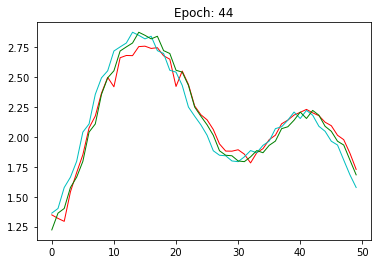

tensor([1.9128, 1.9427, 1.8602, 1.9493, 2.0660, 2.0962, 2.1067, 2.1738, 2.2483,
        2.2796, 2.1708, 2.2583, 2.1566, 2.0918, 2.0355, 1.9878, 1.8414, 1.7229,
        1.6309, 1.4957, 1.5344, 1.2886, 1.0858, 1.1025, 1.0974, 1.1625, 1.1798,
        1.1764, 1.2282, 1.3048, 1.5060, 1.5076, 1.6225, 1.8136, 2.0257, 2.1927,
        2.3484, 2.4904, 2.5992, 2.6720, 2.5469, 2.7372, 2.7697, 2.7314, 2.7703,
        2.7748, 2.7023, 2.6811, 2.6022, 2.5343])
target :  tensor([1.8768, 1.8838, 1.9617, 2.0359, 2.0241, 2.0523, 2.1298, 2.2033, 2.2272,
        2.1448, 2.1871, 2.1439, 2.0860, 2.0019, 1.9310, 1.7817, 1.6783, 1.5946,
        1.4526, 1.4041, 1.2840, 1.2129, 1.1409, 1.0967, 1.1344, 1.1483, 1.1377,
        1.2042, 1.2693, 1.3755, 1.5123, 1.7135, 1.8066, 1.9903, 2.1322, 2.3121,
        2.4772, 2.6137, 2.7119, 2.7770, 2.8027, 2.8727, 2.8426, 2.8775, 2.8665,
        2.7412, 2.7325, 2.6097, 2.5293, 2.3696])
 inputs:  tensor([1.8768, 1.8838, 1.9617, 2.0359, 2.0241, 2.0523, 2.1298, 2.2033, 2.2272,
  

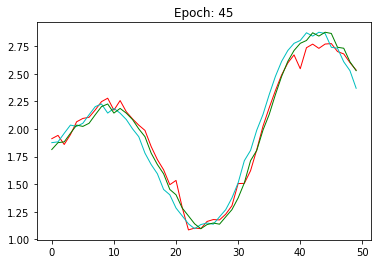

tensor([1.9085, 2.0399, 2.1591, 2.2616, 2.4586, 2.5793, 2.6455, 2.7039, 2.7481,
        2.7961, 2.5831, 2.7723, 2.7264, 2.6530, 2.6168, 2.5506, 2.4964, 2.4389,
        2.3406, 2.2491, 2.1359, 2.0774, 1.9544, 1.8403, 1.8482, 1.8616, 1.8749,
        1.8643, 1.9112, 1.9531, 2.0296, 2.0586, 1.9918, 2.0994, 2.1624, 2.1918,
        2.2357, 2.2290, 2.2311, 2.2023, 2.1215, 2.0515, 1.8566, 1.7624, 1.7375,
        1.6994, 1.5655, 1.4083, 1.2921, 1.2131])
target :  tensor([1.9906, 2.1985, 2.2674, 2.4800, 2.5944, 2.6812, 2.7732, 2.8373, 2.9156,
        2.8639, 2.8665, 2.7949, 2.7412, 2.6612, 2.5572, 2.4970, 2.4245, 2.3045,
        2.2109, 2.1040, 1.9861, 1.9763, 1.8408, 1.8451, 1.8095, 1.8338, 1.8078,
        1.8721, 1.8997, 1.9644, 1.9861, 2.0114, 2.1236, 2.1290, 2.1390, 2.2018,
        2.1793, 2.1909, 2.1553, 2.0844, 1.9597, 1.8747, 1.7777, 1.7318, 1.6485,
        1.5252, 1.3738, 1.2783, 1.1932, 1.2129])
 inputs:  tensor([1.9906, 2.1985, 2.2674, 2.4800, 2.5944, 2.6812, 2.7732, 2.8373, 2.9156,
  

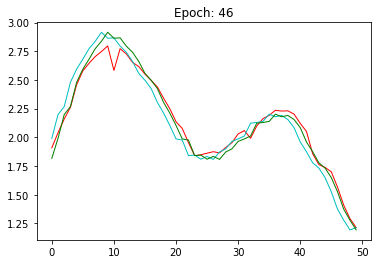

tensor([2.2032, 2.1894, 2.0190, 1.9463, 1.8800, 1.8445, 1.7359, 1.5889, 1.4980,
        1.4365, 1.4563, 1.1922, 0.9914, 1.0959, 1.1119, 1.1284, 1.1558, 1.2200,
        1.3164, 1.4329, 1.6367, 1.6783, 1.7170, 1.9575, 2.1348, 2.3276, 2.4524,
        2.5317, 2.5968, 2.6602, 2.5517, 2.7850, 2.7516, 2.6988, 2.7004, 2.6807,
        2.6414, 2.5883, 2.5038, 2.4282, 2.2615, 2.2600, 2.0932, 1.9468, 1.9440,
        1.9216, 1.8529, 1.8128, 1.8131, 1.8338])
target :  tensor([2.1222, 2.0367, 1.9788, 1.8780, 1.8175, 1.7105, 1.5646, 1.4955, 1.4268,
        1.3452, 1.2249, 1.1441, 1.1618, 1.1133, 1.1084, 1.1496, 1.2040, 1.2987,
        1.4072, 1.5273, 1.6771, 1.7970, 1.9936, 2.1119, 2.3145, 2.4535, 2.5517,
        2.6433, 2.7339, 2.8017, 2.9152, 2.8520, 2.8315, 2.8053, 2.7601, 2.7025,
        2.6315, 2.5201, 2.4351, 2.2920, 2.1965, 2.1044, 1.9690, 1.9616, 1.8868,
        1.8261, 1.7874, 1.7942, 1.8055, 1.9068])
 inputs:  tensor([2.1222, 2.0367, 1.9788, 1.8780, 1.8175, 1.7105, 1.5646, 1.4955, 1.4268,
  

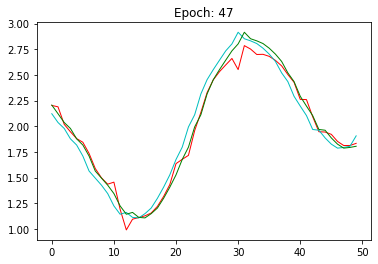

tensor([1.8984, 1.9021, 1.7660, 1.8479, 1.9547, 1.9986, 2.0509, 2.0649, 2.1565,
        2.1982, 2.1798, 2.2432, 2.1718, 2.1610, 2.1547, 2.1180, 2.0667, 2.0035,
        1.8863, 1.7965, 1.6876, 1.5271, 1.2760, 1.2715, 1.2044, 1.2006, 1.1612,
        1.1305, 1.1103, 1.2118, 1.3037, 1.2418, 1.3288, 1.5326, 1.7188, 1.9168,
        2.0390, 2.2060, 2.3120, 2.4736, 2.4472, 2.6362, 2.6993, 2.7200, 2.7546,
        2.7786, 2.7691, 2.7650, 2.7080, 2.6810])
target :  tensor([1.8432, 1.7985, 1.8766, 1.9305, 1.9352, 2.0069, 2.0099, 2.1218, 2.1473,
        2.1553, 2.1727, 2.1740, 2.1743, 2.1302, 2.0671, 2.0252, 1.9558, 1.8380,
        1.7612, 1.5717, 1.5008, 1.3715, 1.3233, 1.2031, 1.1795, 1.1402, 1.1052,
        1.0881, 1.1979, 1.1933, 1.2986, 1.4510, 1.5400, 1.6843, 1.8581, 1.9746,
        2.1619, 2.2663, 2.4707, 2.5722, 2.6550, 2.7841, 2.8427, 2.8502, 2.8815,
        2.8595, 2.8586, 2.7643, 2.7378, 2.5784])
 inputs:  tensor([1.8432, 1.7985, 1.8766, 1.9305, 1.9352, 2.0069, 2.0099, 2.1218, 2.1473,
  

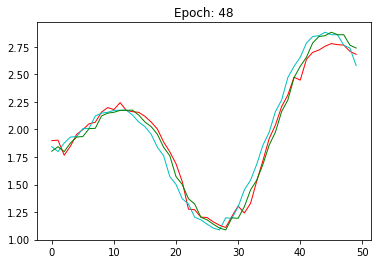

tensor([3.2942, 1.8705, 1.8490, 1.9029, 2.0678, 2.2001, 2.1871, 2.2621, 2.2568,
        2.1937, 2.1694, 2.2274, 2.0523, 2.0266, 1.9041, 1.8365, 1.7348, 1.6720,
        1.5731, 1.4565, 1.4496, 1.2086, 1.0008, 1.1013, 1.1093, 1.1798, 1.2211,
        1.2689, 1.3225, 1.5009, 1.6626, 1.7145, 1.7529, 2.0226, 2.2330, 2.3373,
        2.4453, 2.5897, 2.6841, 2.6963, 2.6115, 2.7896, 2.7969, 2.7410, 2.7483,
        2.7431, 2.6520, 2.5961, 2.5151, 2.4158])
target :  tensor([1.8812, 1.9966, 1.9631, 2.0534, 2.1218, 2.1409, 2.2175, 2.2060, 2.1343,
        2.1309, 2.1495, 2.0348, 2.0429, 1.8655, 1.7948, 1.6965, 1.6361, 1.5333,
        1.4251, 1.3321, 1.2329, 1.1328, 1.1521, 1.0933, 1.1492, 1.1871, 1.2296,
        1.2833, 1.4670, 1.5431, 1.6917, 1.8046, 2.0377, 2.1869, 2.2765, 2.4225,
        2.6069, 2.7201, 2.7309, 2.8722, 2.8669, 2.8933, 2.8544, 2.8340, 2.8150,
        2.6706, 2.6134, 2.5068, 2.3879, 2.3175])
 inputs:  tensor([1.8812, 1.9966, 1.9631, 2.0534, 2.1218, 2.1409, 2.2175, 2.2060, 2.1343,
  

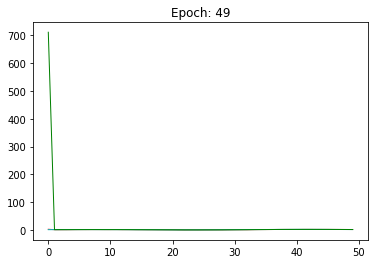

In [87]:
source_data = timeserise_revenue

def fit_by_rnn_model(source_data, n_sample_size, x_size, hidden_size, n_layers, output_size, n_epochs=50, n_iter=50, batch_size=5, lr=1e-2):
    rnn_model = SimpleRNN(x_size=x_size, hidden_size=hidden_size, n_layers=n_layers, batch_size=batch_size, output_size=output_size)
    rnn_model = rnn_model.float()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(rnn_model.parameters(), lr=lr)
    losses = torch.zeros(n_epochs)
    for epoch in tqdm_notebook(range(n_epochs)):
        for n in range(n_iter):
            _inputs, _targets = sample_from_table(n_sample_size, source_data)
            inputs = Variable(
                torch.from_numpy(
                    np.array([
                        _inputs[:10], 
                        _inputs[10:20], 
                        _inputs[20:30], 
                        _inputs[30:40], 
                        _inputs[40:50]], dtype=np.double
                    )
                ).unsqueeze(2)
            )
            targets = Variable(
                torch.from_numpy(
                    np.array([
                        _targets[:10], 
                        _targets[10:20], 
                        _targets[20:30], 
                        _targets[30:40], 
                        _targets[40:50]], dtype=np.double
                    )
                ).unsqueeze(2).float()
            )
            outputs, hidden = rnn_model(inputs.double())
            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            losses[epoch] += loss
            if n % n_iter == 0:
                print( torch.flatten(outputs.detach()))
                print ('target : ', torch.flatten(targets))
                print(' inputs: ', torch.flatten(targets))
                plt.clf()
                plt.ion()
                plt.title(f'Epoch: {epoch}')
                plt.plot(torch.flatten(outputs.detach()), 'r-', linewidth=1, label='Output')
                plt.plot(torch.flatten(targets), 'c-', linewidth=1, label='Target')
                plt.plot(torch.flatten(inputs), 'g-', linewidth=1, label='Input')
                plt.draw()
                plt.pause(0.05)
    return losses
                
losses = fit_by_rnn_model(source_data, n_sample_size, x_size=1, hidden_size=8, 
                 n_layers=n_layers, output_size=1, n_epochs=50, n_iter=50, 
                 batch_size=int(n_sample_size / seq_length), lr=1e-2)